In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.transforms
import seaborn as sns
import math
from math import sqrt, factorial
import re
from itertools import groupby
import scipy
import random
from decimal import Decimal
from operator import itemgetter
#some functions that help find angles between planes

#https://keisan.casio.com/exec/system/1223596129
def plane_eq(points):
    p0 = points[0,:]
    p1 = points[1,:]
    p2 = points[2,:]
    v1 = [p1[0]-p0[0], p1[1]-p0[1], p1[2]-p0[2]]
    v2 = [p2[0]-p0[0], p2[1]-p0[1], p2[2]-p0[2]]
    abc = np.cross(v1, v2)
    d = np.array([abc[0]*p0[0], abc[1]*p0[1], abc[2]*p0[2]])
    return abc, d
# Function to find Angle
def distance(a1, b1, c1, a2, b2, c2):
     
    d = ( a1 * a2 + b1 * b2 + c1 * c2 )
    e1 = math.sqrt( a1 * a1 + b1 * b1 + c1 * c1)
    e2 = math.sqrt( a2 * a2 + b2 * b2 + c2 * c2)
    d = d / (e1 * e2)
    A = math.degrees(math.acos(d))
    return A

def angle(a1, b1, a2, b2):
     
    d = ( a1 * a2 + b1 * b2)
    e1 = math.sqrt( a1 * a1 + b1 * b1)
    e2 = math.sqrt( a2 * a2 + b2 * b2)
    d = d / (e1 * e2)
    A = math.degrees(math.acos(d))
    return A
def closest(lst, K):  
    return lst[min(range(len(lst)), key = lambda i: abs(lst[i]-K))]

In [4]:
#get directories and open separated datasets

time_interval = 10 #sec/frame

datadir = 'D:/Aaron/Data/Combined_Confocal_PCA_with_37Cand6s/'
savedir = datadir + 'alldata/'
if not os.path.exists(savedir):
    os.makedirs(savedir)

TotalFrame = pd.read_csv(datadir + 'Shape_Metrics_transitionPCbins.csv', index_col=0)

nbins = np.max(TotalFrame[[x for x in TotalFrame.columns.to_list() if 'bin' in x]].to_numpy())-1
#open the centers of the binned PCs
centers = pd.read_csv(datadir+'PC_bin_centers.csv', index_col=0)


In [3]:
############### Get Correlation matrix #######################

#stats to remove, if any
to_remove = [i for i in TotalFrame.columns.to_list() if 'Axis' in i] 
# to_remove.extend([i for i in TotalFrame.columns.to_list() if 'Centroid' in i])
to_remove.extend([i for i in TotalFrame.columns.to_list() if 'bin' in i])
# to_remove.extend([i for i in TotalFrame.columns.to_list() if 'intensity' in i])
to_remove.extend([i for i in TotalFrame.columns.to_list() if 'shcoeff' in i])
to_remove.extend([i for i in TotalFrame.columns.to_list() if 'Trajectory' in i])
# to_remove.extend([i for i in TotalFrame.columns.to_list() if 'dist' in i])


#get pearson correlation matrix for TotalFrame without bins
totalcorr = TotalFrame.drop(columns = to_remove)
totalcorr = totalcorr.corr()


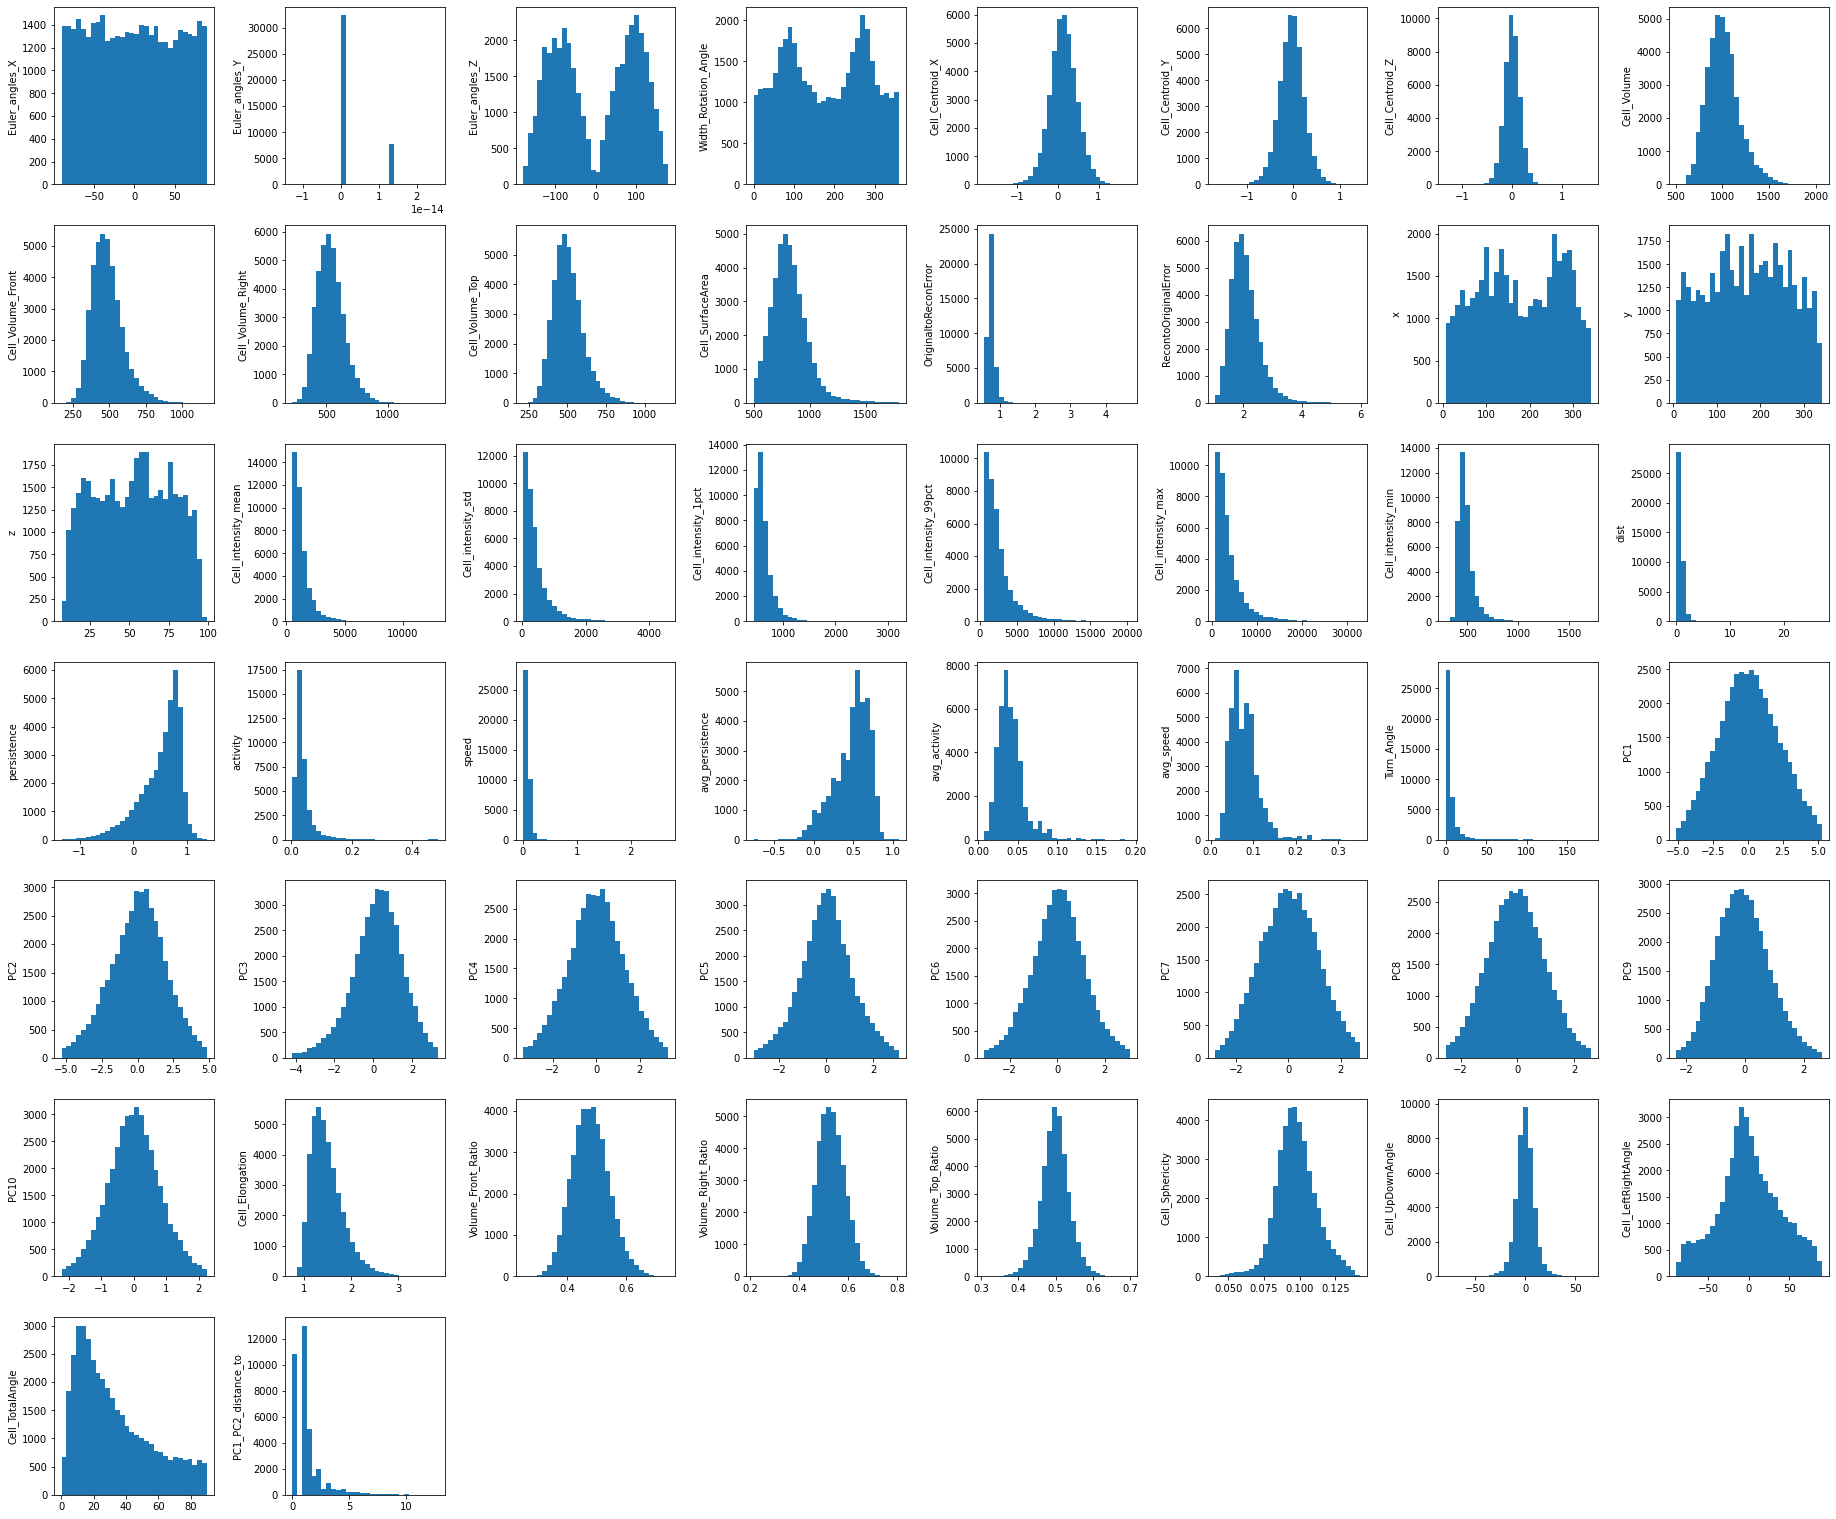

In [7]:
################# LOOK AT STAT DISTRIBUTIONS ######################


# colors = list(sns.color_palette('deep').as_hex())
smallerframe = TotalFrame.drop(columns = to_remove)
smallerframe = smallerframe.drop(columns = ['cell','cell.1','CellID','structure','frame','Treatment'])
CoRo = math.ceil(math.sqrt(len(smallerframe.columns)))
row = 0
fig, axes = plt.subplots(CoRo, CoRo, figsize=(3.2*CoRo,3*CoRo))#, sharex=True)

for i, met in enumerate(smallerframe.columns.to_list()):
    ax = axes[row,(i-((CoRo-1)*row)-row)]
    ax.hist(smallerframe.iloc[:,i], 30)#, color=colors[i]) , 30, (-2,2))
    ax.set_ylabel(smallerframe.iloc[:,i].name)#, fontsize = 1.75*CoRo)
    if (i+1)%(CoRo) ==0:
        row = row + 1

        
#delete all of the subplots that are unused
for a in range(i,CoRo**2):
    fig.delaxes(axes[row,(a-((CoRo-1)*row)-row)])
    if (a+1)%(CoRo) ==0:
        row = row + 1

# #     ax.set_ylabel(Nucleus_Metrics.iloc[:,i].name)

# # axes[0,0].set_title("Cell", fontsize = 16)
# # axes[0,1].set_title("Nucleus", fontsize = 16)
# # [ax.set_xlabel("Component value") for ax in axes[-1,:]];

plt.tight_layout()
# plt.savefig(folder_fl + 'Shape Metric Histograms.png', bbox_inches='tight')

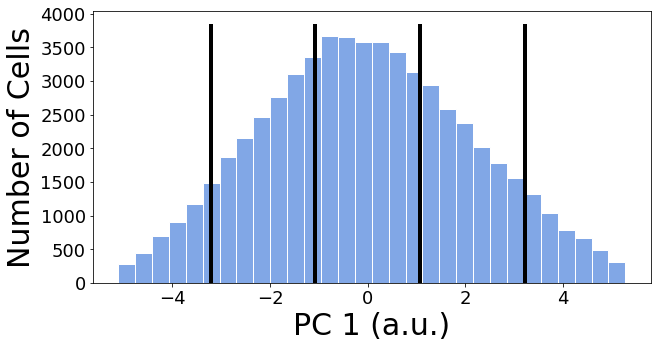

In [4]:
####################### plot distribution of PC1 with Std lines ######################
plt.figure(figsize=(10,5))
dat = TotalFrame.PC1.copy()
plt.hist(dat, color = '#81a7e6',bins=30, edgecolor='white')
plt.ylabel('Number of Cells', fontsize = 30)
plt.xlabel('PC 1 (a.u.)', fontsize = 30)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
ylim = plt.axis()[3]
st = dat.std()
plt.vlines([-((st/2)+st),-st/2, st/2, (st/2)+st], 0, ylim, lw=4, color = 'black')
# plt.vlines(-dat.std(), 0, ylim)
plt.savefig(savedir+ 'PC1 distribution.png', bbox_inches='tight')

In [ ]:
################ how much is rotation of the cell changing from frame to frame ###############



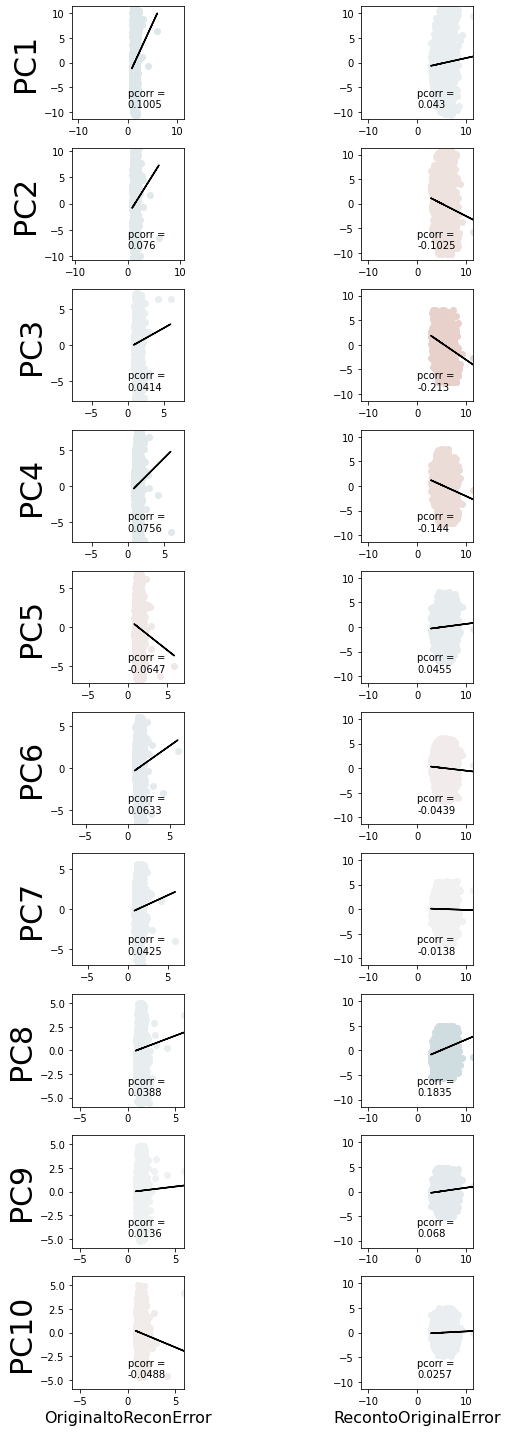

In [22]:
########## correlation between PCs and reconstruction error ###############


color_scale = pd.DataFrame({'color':list(sns.diverging_palette(20, 220, n=200).as_hex()),
              'value':list(np.arange(-1,1,2/200))})
#Scatter plots for cell metrics and the PCs
metric_frame = TotalFrame.loc[:,[x for x in list(TotalFrame.columns) if 'Error' in x]]
PC_frame = TotalFrame.loc[:,[x for x in list(TotalFrame.columns) if 'PC' in x]]
PC_frame = PC_frame.loc[:,[x for x in list(PC_frame.columns) if 'bin' not in x]]
PC_frame = PC_frame.loc[:,[x for x in list(PC_frame.columns) if 'delta' not in x]]

fig, axes = plt.subplots(len(PC_frame.columns), len(metric_frame.columns), figsize=(10,20))#, sharex=True)
for q in range(axes.shape[0]):
    for i, ax in enumerate(axes[q,:]):
        x = metric_frame.iloc[:,i]
        y = PC_frame[f'PC{q+1}']
        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
        p_corr = totalcorr.loc[f'PC{q+1}', metric_frame.iloc[:,i].name]
        color = color_scale.color.loc[color_scale.value == closest(list(color_scale.value), p_corr)].values[0]
        ax.scatter(x,y, color = color)
        ax.plot(x, intercept+slope*x, 'k')
        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
        ax.text(0.5, 0.1, 'pcorr =\n'+str(round(p_corr,4)),transform=ax.transAxes)
        ax.set_aspect('equal','box')
        maxlim = max(x.max(),y.max(), abs(x.min()), abs(y.min()))
        ax.set_xlim(-maxlim,maxlim)
        ax.set_ylim(-maxlim,maxlim)

xlabels = [x.replace('_','\n') for x in metric_frame.columns]
[ax.set_ylabel(PC_frame.columns[i], fontsize = 30) for i, ax in enumerate(axes[:,0])];
[ax.set_xlabel(xlabels[i], fontsize = 16) for i, ax in enumerate(axes[-1,:])];

plt.tight_layout()
# plt.savefig(folder_fl+ 'PC vs. Metric scatter matrix.png', bbox_inches='tight')

In [11]:
ModeFrame

cell  Euler_angles_X  \
19268  20231031_488EGFP-CAAX_0.1percentDMSO_1_cell_0_...      -23.769520   
19269  20231031_488EGFP-CAAX_0.1percentDMSO_1_cell_0_...      -40.984465   
19270  20231031_488EGFP-CAAX_0.1percentDMSO_1_cell_0_...      -30.384763   
19271  20231031_488EGFP-CAAX_0.1percentDMSO_1_cell_0_...      -31.268626   
19272  20231031_488EGFP-CAAX_0.1percentDMSO_1_cell_0_...      -21.068284   
...                                                  ...             ...   
59530  20231113_488EGFP-CAAX_10uMParaNitroBleb_3_cell...      -10.064576   
59531  20231113_488EGFP-CAAX_10uMParaNitroBleb_3_cell...      -81.617515   
59532  20231113_488EGFP-CAAX_10uMParaNitroBleb_3_cell...      -10.845461   
59533  20231113_488EGFP-CAAX_10uMParaNitroBleb_3_cell...      -22.166561   
59534  20231113_488EGFP-CAAX_10uMParaNitroBleb_3_cell...       -6.906174   

       Euler_angles_Y  Euler_angles_Z  Width_Rotation_Angle  Cell_Centroid_X  \
19268    0.000000e+00      -98.166905                 249.0         0.612689   
19269    1.272222e-14     -105.253105                 294.0         0.595268   
19270    0.000000e+00     -107.048778                 264.5         0.712256   
19271    0.000000e+00     -107.404515                 270.5         0.271753   
19272    0.000000e+00      -92.274089                  29.5         0.312551   
...               ...             ...                   ...              ...   
59530    0.000000e+00     -128.988255                 130.5         0.013543   
59531    1.272222e-14     -107.806092                  45.5        -0.034163   
59532    0.000000e+00     -128.494816                 136.5        -0.538924   
59533    0.000000e+00     -127.570405                 273.5         0.162296   
59534    0.000000e+00     -144.516065                 295.0         0.031669   

       Cell_Centroid_Y  Cell_Centroid_Z  Cell_Volume  Cell_Volume_Front  ...  \
19268         0.263711         0.061044   887.317141         420.610669  ...   
19269         0.067988         0.022399   972.944423         497.483140  ...   
19270        -0.096596        -0.064128   924.294872         483.519482  ...   
19271        -0.025457        -0.102630   931.602369         495.786471  ...   
19272        -0.239831         0.111925   973.922125         465.716644  ...   
...                ...              ...          ...                ...  ...   
59530        -0.160600         0.052919   793.639842         383.574640  ...   
59531         0.740293         0.087557   723.524643         390.364288  ...   
59532        -0.069760         0.303790   741.348263         387.273306  ...   
59533         0.238892         0.041879   808.873076         338.268256  ...   
59534         0.440222        -0.116258   819.993927         430.490081  ...   

       Cell_UpDownAngle  Cell_LeftRightAngle  Cell_TotalAngle  PC1bins  \
19268         -2.025527           -17.821869        17.944332        4   
19269          7.674421           -23.763477        25.119916        6   
19270          5.493973            -1.376368         5.664786        5   
19271          9.775410            -3.980687        10.569624        5   
19272         31.455658           -57.297771        81.956390        8   
...                 ...                  ...              ...      ...   
59530        -15.294170            -6.410081        16.644282        4   
59531         -4.771356           -82.429589        84.136127        9   
59532        -14.580665            -3.470498        15.005908        4   
59533          2.398358            11.481101        11.735623        6   
59534         14.395492            56.082059        60.029065       11   

       PC2bins  PC3bins  PC4bins  PC1_PC2_distance_to  PC1_PC2_distance_from  \
19268        7        7        6             1.000000               0.000000   
19269        8        7        6             1.000000               1.000000   
19270        7        7        6             0.000000               0.000000   
19271   

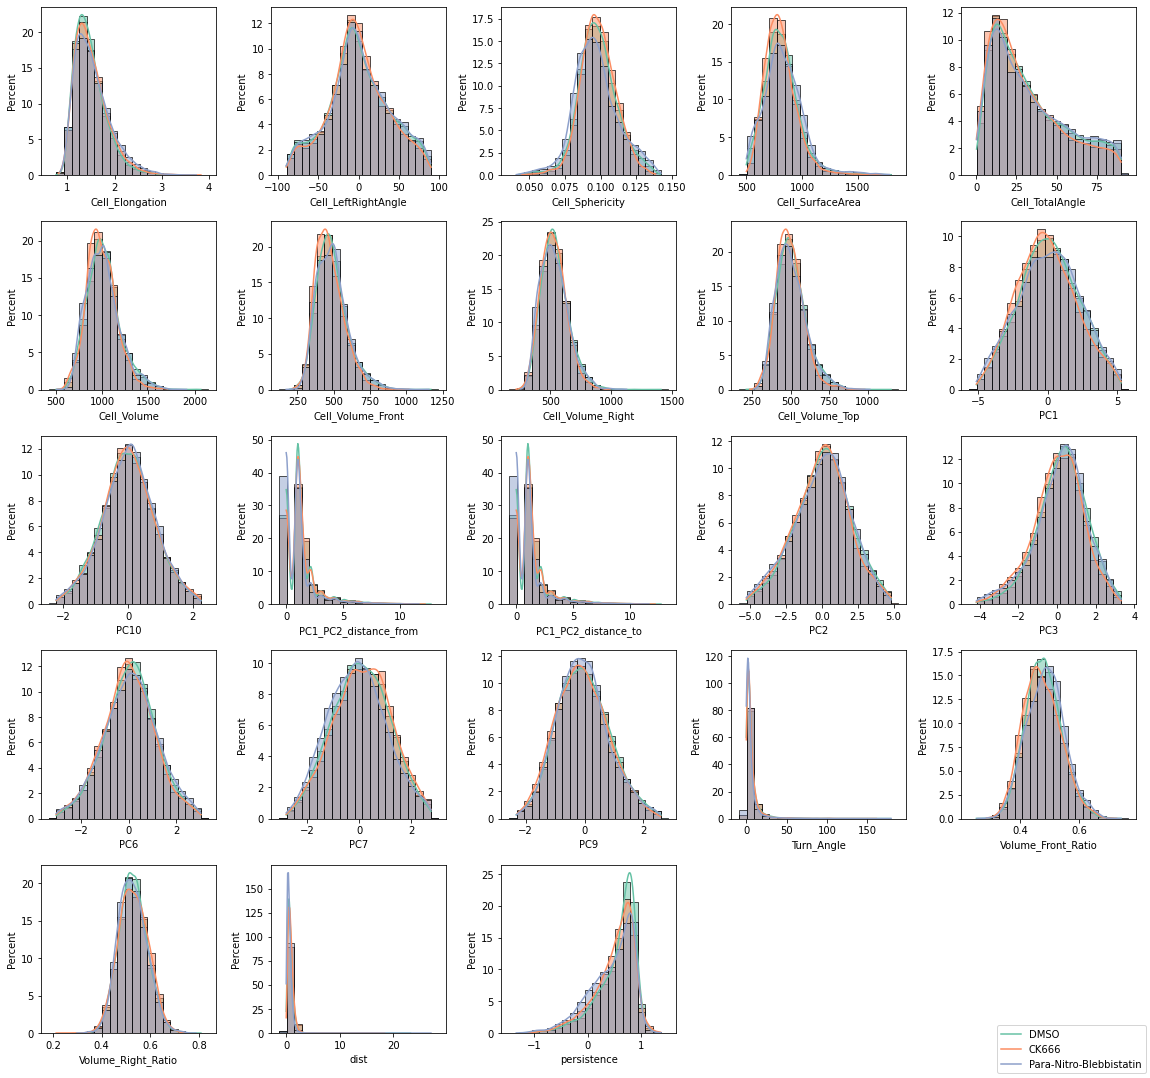

In [25]:
################# LOOK AT STAT DISTRIBUTIONS OF SIGNIFICANT STATS ######################
import seaborn as sns

colors = sns.color_palette("Set2")
colors = list(colors.as_hex())


# colors = list(sns.color_palette('deep').as_hex())
smallerframe = TotalFrame[siglist]
CoRo = math.ceil(math.sqrt(len(smallerframe.columns)))
row = 0
fig, axes = plt.subplots(CoRo, CoRo, figsize=(3.2*CoRo,3*CoRo))#, sharex=True)

for i, met in enumerate(smallerframe.columns.to_list()):

    
    #get the metric in question separated by migration mode
    samples = [g[1].dropna() for g in ModeFrame.groupby('Treatment')[met]]
    
        
    #get bins so that the widths between all types are the same
    maxx = max([max(x) for x in samples])
    minn = min([min(x) for x in samples])
    binwidth = (maxx-minn)*0.05
    maxx = maxx + binwidth
    minn = minn - binwidth
    binss = np.linspace(minn,maxx,round((maxx-minn)/binwidth))
    
    #plot the data
    ax = axes[row,(i-((CoRo-1)*row)-row)]
    sns.histplot(ax = ax, data=samples[0], bins=binss, stat='percent', color = colors[0], kde = True)
    sns.histplot(ax = ax, data=samples[1], bins=binss, stat='percent', color = colors[1], kde = True)
    sns.histplot(ax = ax, data=samples[2], bins=binss, stat='percent', color = colors[2], kde = True)
#     ax.set_ylabel(met)#, fontsize = 1.75*CoRo)
    if (i+1)%(CoRo) ==0:
        row = row + 1


ax = axes[row,(i-((CoRo-1)*row)-row)]
fig.legend(ModeFrame.Treatment.unique(), loc = 'lower right')

#delete all of the subplots that are unused
for a in range(i,CoRo**2):
    fig.delaxes(axes[row,(a-((CoRo-1)*row)-row)])
    if (a+1)%(CoRo) ==0:
        row = row + 1

# #     ax.set_ylabel(Nucleus_Metrics.iloc[:,i].name)

# # axes[0,0].set_title("Cell", fontsize = 16)
# # axes[0,1].set_title("Nucleus", fontsize = 16)
# # [ax.set_xlabel("Component value") for ax in axes[-1,:]];
# plt.legend(ModeFrame.Migration_Mode.unique(), loc ='lower right')
plt.tight_layout()
plt.savefig(savedir + 'Significant Shape Metric Histograms.png', bbox_inches='tight')

In [70]:
len(TotalFrame.CellID.unique()), len(TotalFrame)

(734, 59535)

In [19]:
#get the number of images of cells and unique cells per migration mode
samplesize = pd.DataFrame([])

for m, mod in TotalFrame.groupby('CellID'):
    imnum = len(mod)
    cellnum = len(mod.CellID.unique())
    samplesize = samplesize.append(pd.DataFrame({'Treatment':m,
                                                 'Cells':cellnum, 
                                                'Images':imnum}, index = [0]))

samplesize = samplesize.reset_index(drop=True)
samplesize

Treatment  Cells  Images
0                     DMSO    287   22027
1                    CK666     84    8264
2  Para-Nitro-Blebbistatin    144    9976

C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


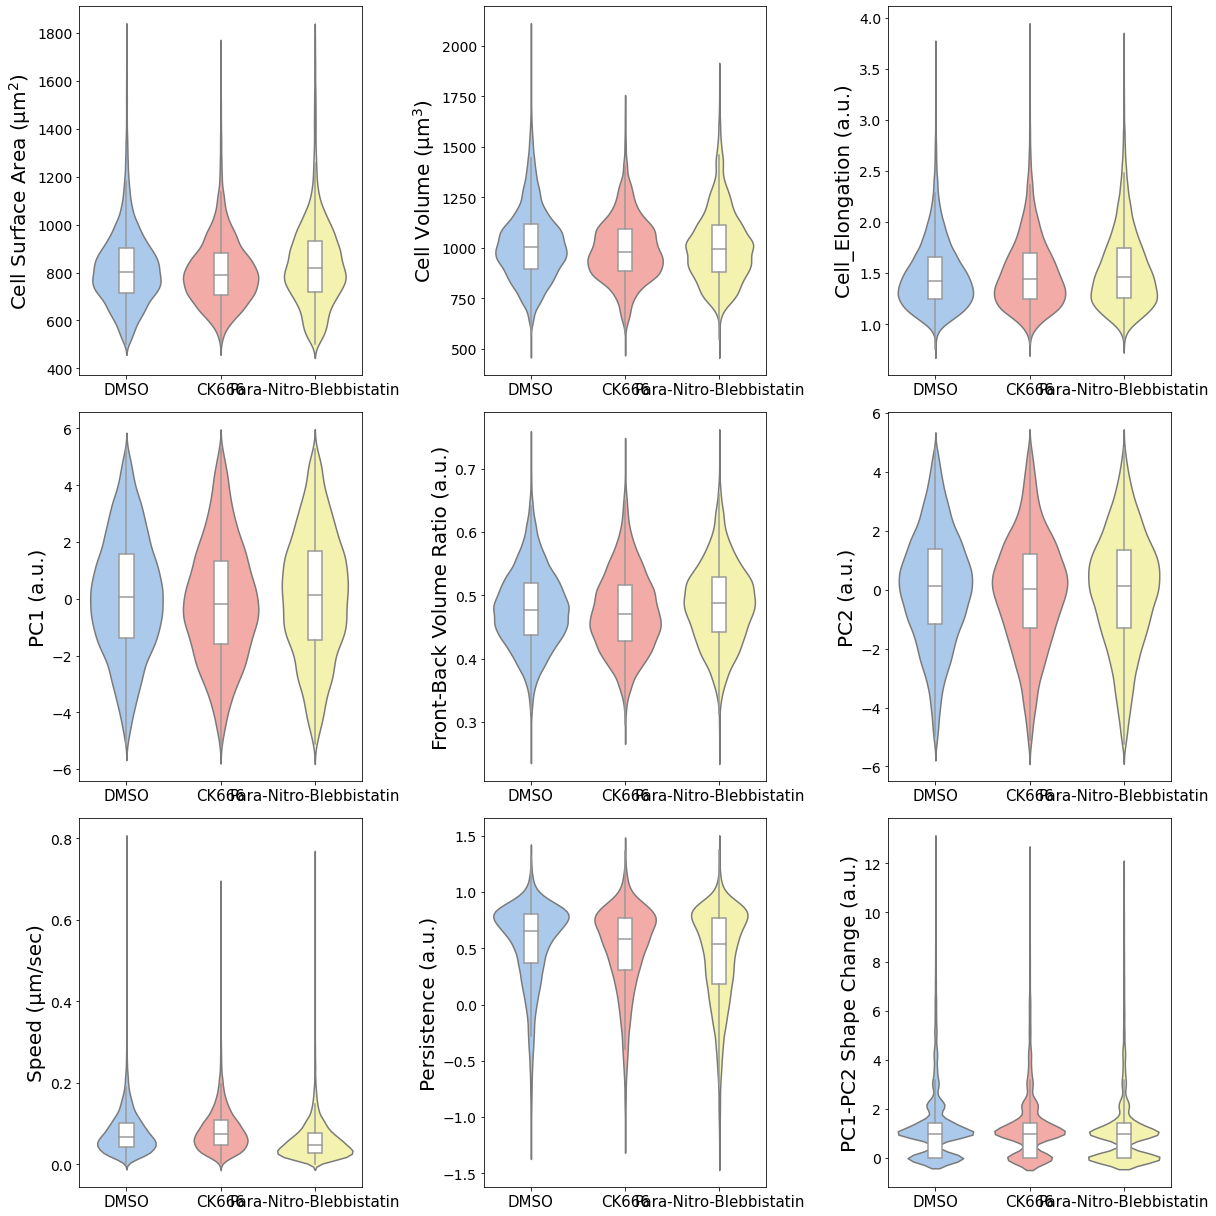

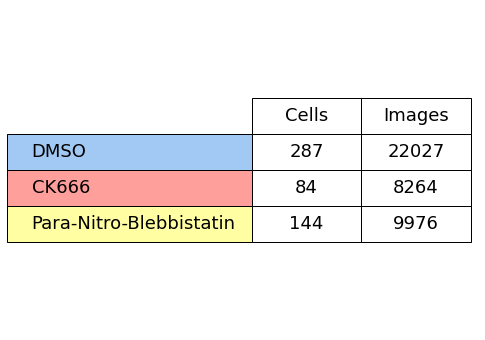

In [24]:
############### Metric distributions by gene #################################

import re

angles = []
for i, row in TotalFrame.iterrows():
    angles.append(distance(row.Trajectory_X,row.Trajectory_Y,row.Trajectory_Z,1,0,0))
#     angles.append(angle(row.Trajectory_X,row.Trajectory_Y,1,0))
TotalFrame['Angular Bias'] = angles

#### remove speed outliers
tempframe = TotalFrame[TotalFrame.speed<0.8]

colorlist = [list(sns.color_palette('pastel').as_hex())[i] for i in [0,3,8]]

smallersig = ['Cell_SurfaceArea','Cell_Volume','Cell_Elongation','PC1','Volume_Front_Ratio','PC2','speed','persistence','PC1_PC2_distance_to']
siglabels = ['Cell Surface Area (µm$^2$)','Cell Volume (µm$^3$)','Cell_Elongation (a.u.)','PC1 (a.u.)',
             'Front-Back Volume Ratio (a.u.)','PC2 (a.u.)','Speed (µm/sec)','Persistence (a.u.)','PC1-PC2 Shape Change (a.u.)']


fig, axes = plt.subplots(3, 3, figsize=(17,17))#, sharex=True)
axli = axes.flatten()
# for m, mig in tempframe.groupby('Migration_Mode'):
for i, sig in enumerate(smallersig):
    vp = sns.violinplot(data=tempframe, x='Treatment', y=sig, palette = colorlist, inner = None, ax=axli[i], )
    bp = sns.boxplot(data=tempframe, x='Treatment', y=sig, width = 0.15, 
            color = 'white', showcaps=False, fliersize=0, boxprops={'zorder': 2}, ax=axli[i])
    axli[i].set_ylabel(siglabels[i], fontsize=20)
    axli[i].set_xlabel('', fontsize=20)
    axli[i].tick_params('y', labelsize=14)
    axli[i].set_xticklabels(samplesize['Treatment'].to_list(), fontsize = 15)


plt.tight_layout()
plt.savefig(savedir + 'treatment significant metric violins.png', bbox_inches='tight')




fig, ax = plt.subplots(1, 1, figsize=(7,6))#, sharex=True)     
tb = ax.table(cellText=samplesize.values[:,1:],
      rowLabels=samplesize.values[:,0],
      rowColours=colorlist,
      colLabels=samplesize.columns[1:].to_list(),
        loc= 'center right',
        cellLoc = 'center',
        colWidths = [0.35]*len(samplesize))
tb.scale(0.8,3)
tb.auto_set_font_size(False)
tb.set_fontsize(18)
ax.axis('off')
plt.savefig(savedir + 'treatment significant metric table.png', bbox_inches='tight')




In [21]:
############### get list of metrics that are significant by migration mode using anova ############
ModeFrame = TotalFrame.copy()

import scipy.stats as ss
siglist = []
new_remove = to_remove.copy()
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'cell' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'frame' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'angle' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'avg' in x])
# new_remove.extend([x for x in ModeFrame.columns.to_list() if 'dist' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'activity' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'structure' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'ID' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'Experiment' in x])
# new_remove.extend([x for x in ModeFrame.columns.to_list() if 'Migration_Mode' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'intensity' in x])
new_remove.extend(['x','y','z','OriginaltoReconError', 'RecontoOriginalError', 'Width_Rotation_Angle',
                   'Cell_Centroid_X', 'Cell_Centroid_Y', 'Cell_Centroid_Z'])
for c in ModeFrame.drop(columns=new_remove).columns.to_list():
    if c != 'Treatment':
        samples = [g[1].dropna() for g in ModeFrame.groupby('Treatment')[c]]
        f_val, p_val = ss.f_oneway(*samples)
        print(f'Name: {c}, F value: {f_val}, p value: {p_val}')
        if p_val < 0.05:
            siglist.append(c) 
siglist = sorted(siglist)
# from statsmodels.stats.multicomp import pairwise_tukeyhsd
# for c in siglist:
#     print(f'Name {c}', pairwise_tukeyhsd(GeneFrame[c], GeneFrame['Gene']))

# units= ['(a.u.)','(a.u.)','(µm$^3$)','(a.u.)','(a.u.)','(µm$^2$)','(µm$^3$)',
#         '(a.u.)','(a.u.)']

Name: Cell_Volume, F value: 63.36372538214007, p value: 3.3473346429021904e-28
Name: Cell_Volume_Front, F value: 105.95759172780184, p value: 1.2702109645216206e-46
Name: Cell_Volume_Right, F value: 37.34359247202985, p value: 6.264797994129354e-17
Name: Cell_Volume_Top, F value: 50.71519345437689, p value: 1.0054655643215446e-22
Name: Cell_SurfaceArea, F value: 67.96482929964989, p value: 3.411626708829781e-30
Name: dist, F value: 299.53289245517004, p value: 7.460355997134934e-130
Name: persistence, F value: 274.395973331484, p value: 4.5572815647834787e-119
Name: speed, F value: 299.2641768245615, p value: 1.0015516886733044e-129
Name: Turn_Angle, F value: 44.132124083707396, p value: 7.160194488428832e-20
Name: PC1, F value: 31.924784501178113, p value: 1.4003088297084605e-14
Name: PC2, F value: 18.95521618388687, p value: 5.9119023446811606e-09
Name: PC3, F value: 89.22850897945817, p value: 2.158611969790007e-39
Name: PC4, F value: 0.14745428356899254, p value: 0.8629023521872623

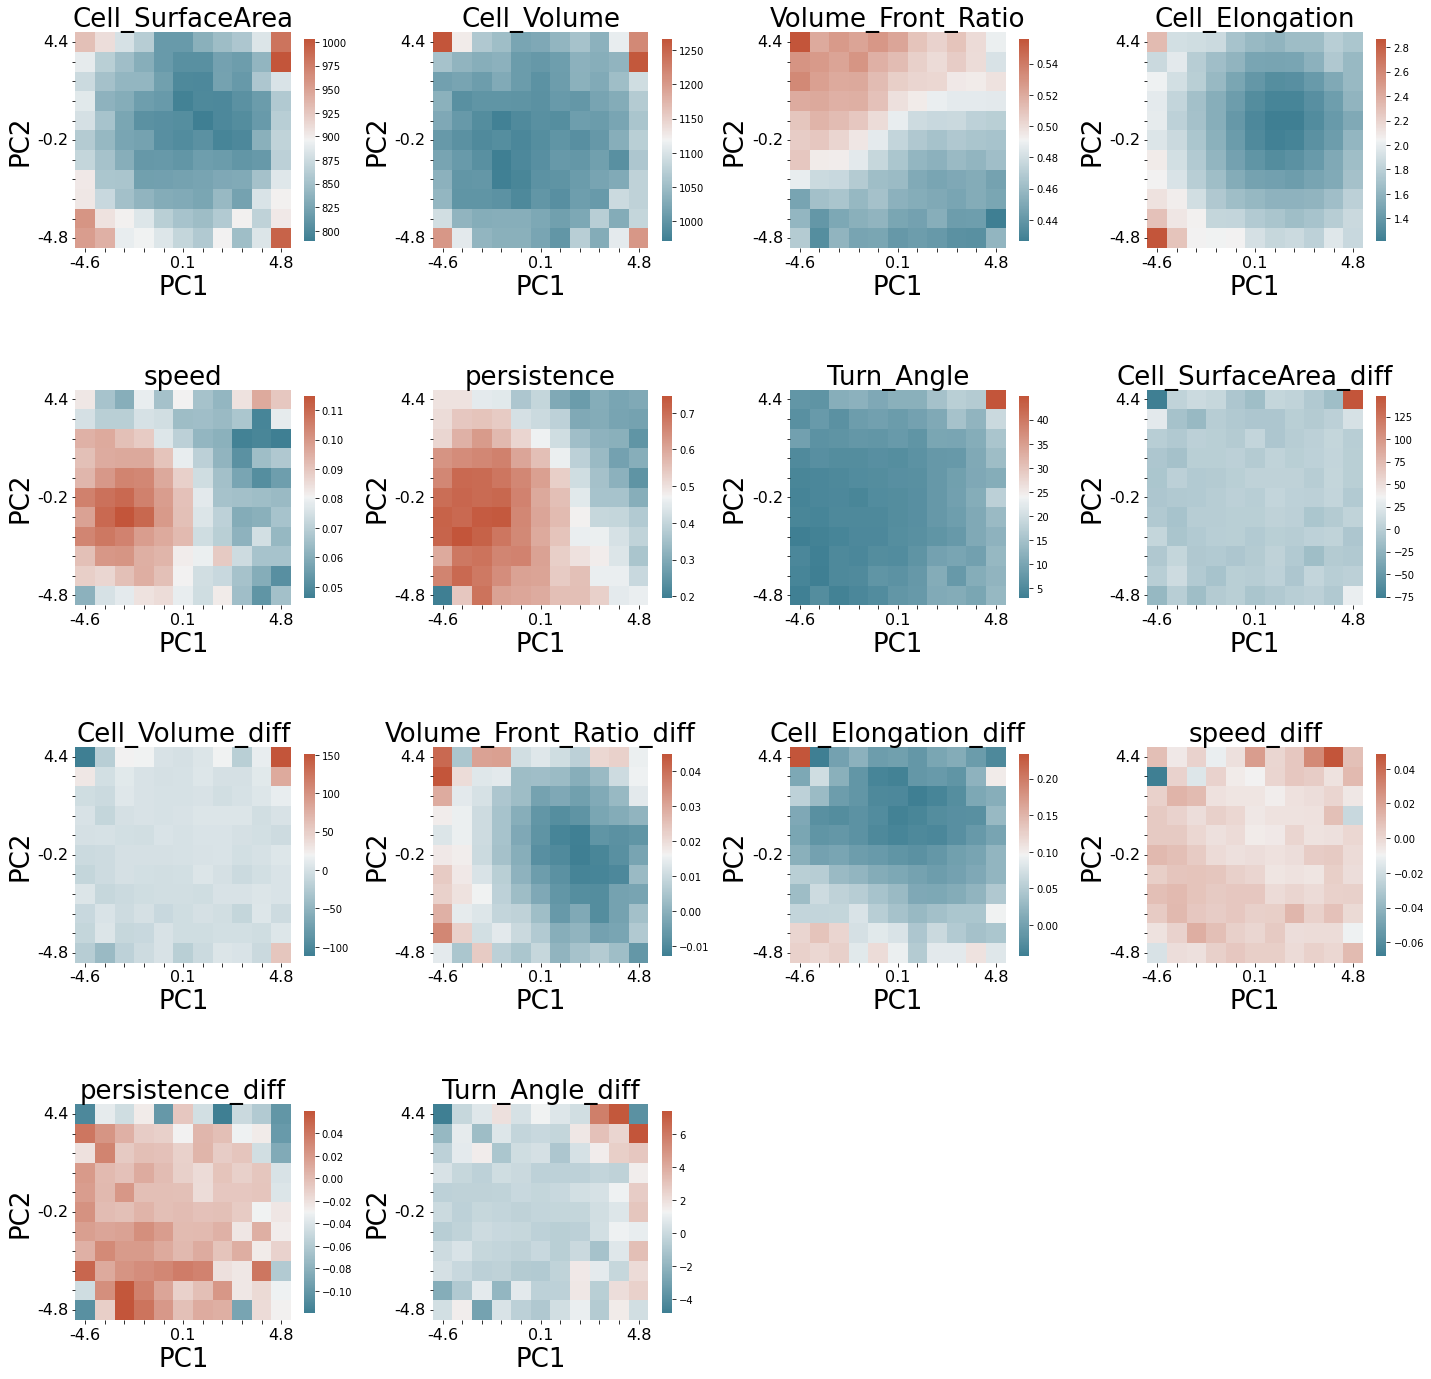

In [5]:
########### PLOT THE DISTRIBUTIONS OF SHAPE METRICS FROM THE SEPARATED MIGRATION MODES #############
############ IN THE COARSE GRAINED PHASE SPACE ###############

#add some metric differentials
metrics = ['Cell_SurfaceArea','Cell_Volume','Volume_Front_Ratio','Cell_Elongation','speed','persistence','Turn_Angle']
TotalFrame = TotalFrame.sort_values(['CellID','frame'])
diffmets = metrics.copy()
for d in metrics:
    TotalFrame[d+'_diff'] = TotalFrame[d].diff()
    diffmets.append(d+'_diff')

#make subplots
sp = math.ceil(math.sqrt(len(diffmets)))
fig, axes = plt.subplots(sp,sp,figsize=(sp*5,sp*5))

for i, ax in enumerate(axes.flatten()):
    if i<len(diffmets):
        ################ heatmap of the given metric #############
        #make numpy array with heatmap data
        bighm = np.zeros((nbins,nbins))
        for x in range(nbins):
            for y in range(nbins):
                current =  TotalFrame[(TotalFrame['PC1bins'] == x+1) & (TotalFrame['PC2bins'] == y+1)]
                if current.empty:
                    bighm[y,x] = 0
                elif len(current)==1:
                    bighm[y,x] = current[diffmets[i]]
                else:
                    bighm[y,x] = current[diffmets[i]].mean()


        #plot heatmap with seaborn
        #### use the max and the lowest non zero as min
        sns.heatmap(
            bighm,
            vmin=np.min(bighm[np.nonzero(bighm)]),
            vmax=bighm.max(), #center=0,
            cmap=sns.diverging_palette(220, 20, n=200),
            square=True,
            xticklabels = True,
            yticklabels = True,
            ax = ax,
            cbar_kws={'shrink': 0.65}
        )
        ax.set_xticklabels(
            [round((PC1bins[i+1]+x)/2,1) for i,x in enumerate(PC1bins[:-1])],
            fontsize = 16
        )
        ax.set_yticklabels(
            [round((PC2bins[i+1]+x)/2,1) for i,x in enumerate(PC2bins[:-1])],
            rotation=0,
            fontsize = 16
        )
        #take out all axis labels except the desired ones
        for o, l in enumerate(ax.xaxis.get_ticklabels()):
            if o%5 != 0:
                l.set_visible(False)
        for o, l in enumerate(ax.yaxis.get_ticklabels()):
            if o%5 != 0:
                l.set_visible(False)
        #set axis titles
        ax.set_xlabel('PC1', fontsize = 26)
        ax.set_ylabel('PC2', fontsize = 26)
        #correct axis orientations
        ax.invert_yaxis()
        #set title
        ax.set_title(diffmets[i], fontsize = 26)
    else:
        ax.remove()

# adjust colorbar tick label size
# cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(),fontsize=18)
#set axis title
axes.flatten()[0].set_ylabel('PC2', fontsize = 26)

plt.tight_layout()
plt.savefig(savedir + 'PC1_PC2 metric heatmaps.png', bbox_inches='tight')

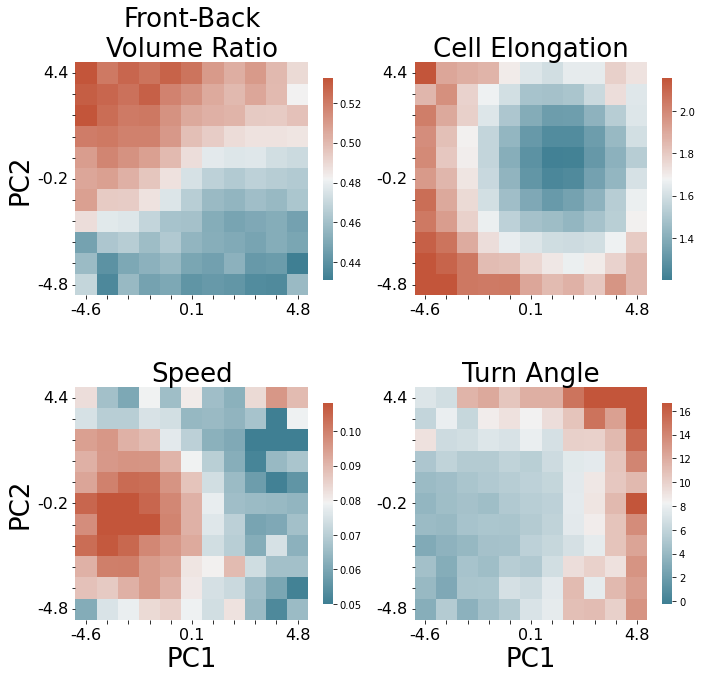

In [67]:
#################### PLOT FOR ASCB 2023 #####################

########### PLOT THE DISTRIBUTIONS OF SHAPE METRICS FROM THE SEPARATED MIGRATION MODES #############
############ IN THE COARSE GRAINED PHASE SPACE ###############

#add some metric differentials
metrics = ['Volume_Front_Ratio','Cell_Elongation','speed','Turn_Angle']
Metricnames = ['Front-Back\nVolume Ratio', 'Cell Elongation','Speed','Turn Angle']
TotalFrame = TotalFrame.sort_values(['CellID','frame'])
diffmets = metrics.copy()

#make subplots
sp = math.ceil(math.sqrt(len(diffmets)))
fig, axes = plt.subplots(sp,sp,figsize=(sp*5,sp*5))

for i, ax in enumerate(axes.flatten()):
    if i<len(diffmets):
        ################ heatmap of the given metric #############
        #make numpy array with heatmap data
        bighm = np.zeros((nbins,nbins))
        for x in range(nbins):
            for y in range(nbins):
                current =  TotalFrame[(TotalFrame['PC1bins'] == x+1) & (TotalFrame['PC2bins'] == y+1)]
                if current.empty:
                    bighm[y,x] = 0
                elif len(current)==1:
                    bighm[y,x] = current[diffmets[i]]
                else:
                    bighm[y,x] = current[diffmets[i]].mean()


        #plot heatmap with seaborn
        #### use the max and the lowest non zero as min
        sns.heatmap(
            bighm,
            vmin=bighm.mean()-(bighm.std()*1.75),#np.min(bighm[np.nonzero(bighm)]),
            vmax=bighm.mean()+(bighm.std()*1.75),#bighm.max(), #center=0,
            cmap=sns.diverging_palette(220, 20, n=200),
            square=True,
            xticklabels = True,
            yticklabels = True,
            ax = ax,
            cbar_kws={'shrink': 0.65}
        )
        ax.set_xticklabels(
            [round((PC1bins[i+1]+x)/2,1) for i,x in enumerate(PC1bins[:-1])],
            fontsize = 16
        )
        ax.set_yticklabels(
            [round((PC2bins[i+1]+x)/2,1) for i,x in enumerate(PC2bins[:-1])],
            rotation=0,
            fontsize = 16
        )
        #take out all axis labels except the desired ones
        for o, l in enumerate(ax.xaxis.get_ticklabels()):
            if o%5 != 0:
                l.set_visible(False)
        for o, l in enumerate(ax.yaxis.get_ticklabels()):
            if o%5 != 0:
                l.set_visible(False)
        #set axis titles
        if i==0:
            ax.set_ylabel('PC2', fontsize = 26)
        if i == 2:
            ax.set_xlabel('PC1', fontsize = 26)
            ax.set_ylabel('PC2', fontsize = 26)
        if i == 3:
            ax.set_xlabel('PC1', fontsize = 26)
        #correct axis orientations
        ax.invert_yaxis()
        #set title
        ax.set_title(Metricnames[i], fontsize = 26)
    else:
        ax.remove()

# adjust colorbar tick label size
# cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(),fontsize=18)
#set axis title
# axes.flatten()[0].set_ylabel('PC2', fontsize = 26)

plt.tight_layout()
plt.savefig(savedir + 'PC1_PC2 metric heatmaps ASCB 2023.png', bbox_inches='tight', dpi=500)

In [ ]:
########### PLOT THE DISTRIBUTIONS OF SHAPE METRIC DIFFERENTIALS FROM THE SEPARATED MIGRATION MODES #############
############ IN THE COARSE GRAINED PHASE SPACE ###############

metrics = ['Cell_SurfaceArea','Cell_Volume','speed','persistence','Turn_Angle']

sp = math.ceil(math.sqrt(len(metrics)))

fig, axes = plt.subplots(sp,sp,figsize=(sp*5,sp*5))

for i, ax in enumerate(axes.flatten()):
    if i<len(metrics):
        ################ heatmap of the given metric #############
        #make numpy array with heatmap data
        bighm = np.zeros((nbins,nbins))
        for x in range(nbins):
            for y in range(nbins):
                current =  TotalFrame[(TotalFrame['PC1bins'] == x+1) & (TotalFrame['PC2bins'] == y+1)]
                if current.empty:
                    bighm[y,x] = 0
                elif len(current)==1:
                    bighm[y,x] = current[metrics[i]]
                else:
                    bighm[y,x] = current[metrics[i]].mean()


        #plot heatmap with seaborn
        #### use the max and the lowest non zero as min
        sns.heatmap(
            bighm,
            vmin=np.min(bighm[np.nonzero(bighm)]),
            vmax=bighm.max(), #center=0,
            cmap=sns.diverging_palette(220, 20, n=200),
            square=True,
            xticklabels = True,
            yticklabels = True,
            ax = ax,
            cbar_kws={'shrink': 0.65}
        )
        ax.set_xticklabels(
            [round((PC1bins[i+1]+x)/2,1) for i,x in enumerate(PC1bins[:-1])],
            fontsize = 16
        )
        ax.set_yticklabels(
            [round((PC2bins[i+1]+x)/2,1) for i,x in enumerate(PC2bins[:-1])],
            rotation=0,
            fontsize = 16
        )
        #take out all axis labels except the desired ones
        for o, l in enumerate(ax.xaxis.get_ticklabels()):
            if o%5 != 0:
                l.set_visible(False)
        for o, l in enumerate(ax.yaxis.get_ticklabels()):
            if o%5 != 0:
                l.set_visible(False)
        #set axis titles
        ax.set_xlabel('PC1', fontsize = 26)
        ax.set_ylabel('PC2', fontsize = 26)
        #correct axis orientations
        ax.invert_yaxis()
        #set title
        ax.set_title(metrics[i], fontsize = 26)
    else:
        ax.remove()

# adjust colorbar tick label size
cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(),fontsize=18)
#set axis title
axes.flatten()[0].set_ylabel('PC2', fontsize = 26)

plt.tight_layout()
plt.savefig(savedir + 'PC1_PC2 metric heatmaps.png', bbox_inches='tight')

C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:73: UserWarning: FixedFormatter should only be used together with FixedLocator


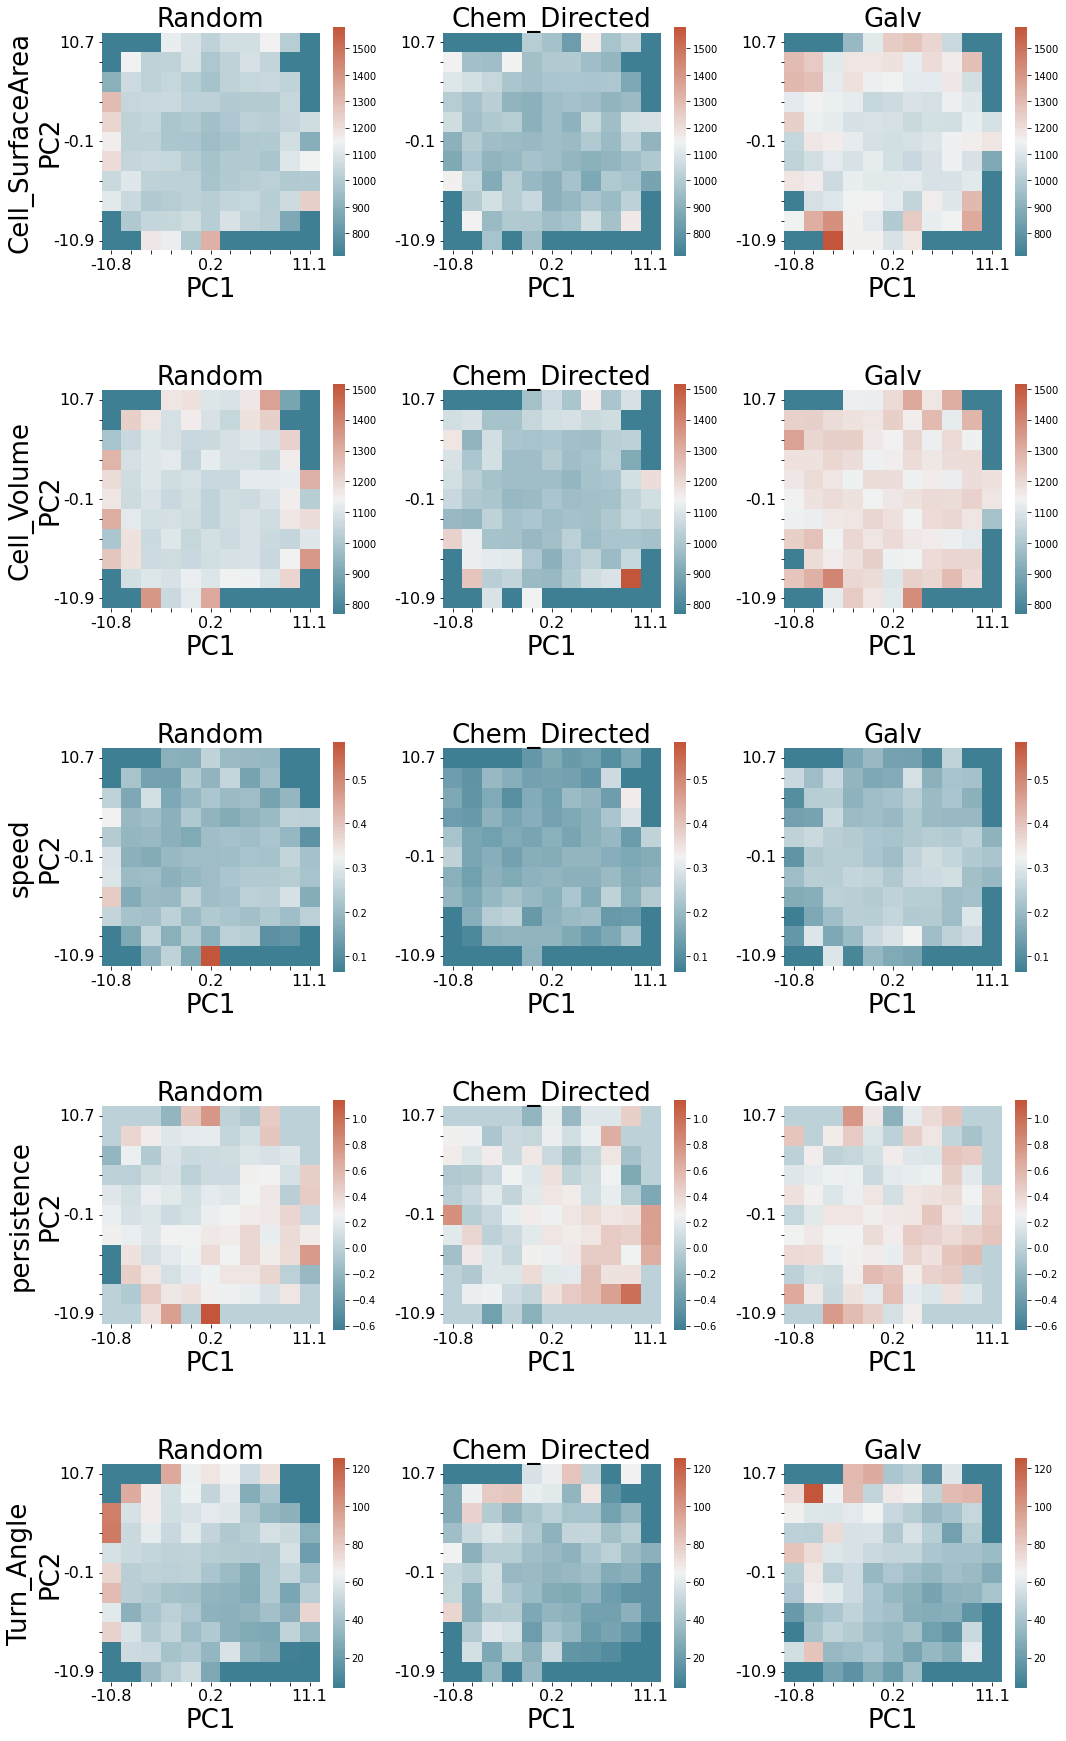

In [181]:
########### PLOT THE DISTRIBUTIONS OF SHAPE METRICS FROM THE SEPARATED MIGRATION MODES #############
############ IN THE COARSE GRAINED PHASE SPACE ###############

metrics = ['Cell_SurfaceArea','Cell_Volume','speed','persistence','Turn_Angle']

sp = math.ceil(math.sqrt(len(metrics)))

fig, axes = plt.subplots(len(metrics),len(TotalFrame.Migration_Mode.unique()),figsize=(15,len(metrics)*5))


for i, met in enumerate(metrics):
    for a, ax in enumerate(axes[i]):
        mm = TotalFrame.Migration_Mode.unique()[a]
        mdf = TotalFrame[TotalFrame.Migration_Mode==mm]
        ################ heatmap of the given metric #############
        #make numpy array with heatmap data
        bighm = np.zeros((len(axes[i]),nbins,nbins))
        for n in range(bighm.shape[0]):
            mdf = TotalFrame[TotalFrame.Migration_Mode==TotalFrame.Migration_Mode.unique()[n]]
            for x in range(nbins):
                for y in range(nbins):
                    current =  mdf[(mdf['PC1bins'] == x+1) & (mdf['PC2bins'] == y+1)].dropna(subset=[met])
                    if current.empty:
                        bighm[n,y,x] = 0
                    elif len(current)==1:
                        bighm[n,y,x] = current[met]
                    else:
                        bighm[n,y,x] = current[met].mean()


        #plot heatmap with seaborn
        #### use the max and the lowest non zero as min
        sns.heatmap(
            bighm[a,:,:],
            vmin=np.min(bighm[np.nonzero(bighm)]),
            vmax=np.max(bighm), #center=0,
            cmap=sns.diverging_palette(220, 20, n=200),
            square=True,
            xticklabels = True,
            yticklabels = True,
            ax = ax,
            cbar_kws={'shrink': 0.75}
        )
        ax.set_xticklabels(
            [round((PC1bins[i+1]+x)/2,1) for i,x in enumerate(PC1bins[:-1])],
            fontsize = 16
        )
        ax.set_yticklabels(
            [round((PC2bins[i+1]+x)/2,1) for i,x in enumerate(PC2bins[:-1])],
            rotation=0,
            fontsize = 16
        )
        #take out all axis labels except the desired ones
        for o, l in enumerate(ax.xaxis.get_ticklabels()):
            if o%5 != 0:
                l.set_visible(False)
        for o, l in enumerate(ax.yaxis.get_ticklabels()):
            if o%5 != 0:
                l.set_visible(False)
        #set axis titles
        ax.set_xlabel('PC1', fontsize = 26)      
        if (a == 0):
            ax.set_ylabel(f'{met}\nPC2', fontsize = 26, labelpad=-10)
#         else:
#             ax.set_ylabel(f'PC2', fontsize = 26, labelpad=-10)
        #correct axis orientations
        ax.invert_yaxis()
        #set title
        ax.set_title(mm, fontsize = 26)


# adjust colorbar tick label size
cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(),fontsize=18)
#set axis title

plt.tight_layout()
plt.savefig(savedir + 'PC1_PC2 metric heatmaps separated.png', bbox_inches='tight')

C:\Users\Aaron\AppData\Roaming\Python\Python37\site-packages\scipy\stats\stats.py:3621: F_onewayBadInputSizesWarning: at least one input has length 0
  warnings.warn(F_onewayBadInputSizesWarning('at least one input '


Name Cell_Centroid_X          Multiple Comparison of Means - Tukey HSD, FWER=0.05         
      group1          group2   meandiff p-adj  lower    upper  reject
---------------------------------------------------------------------
Chem_Directed_Chem   Galv_Galv  13.8299   0.0  12.5991 15.0607   True
Chem_Directed_Chem Random_Chem   2.3165   0.0   1.1808  3.4522   True
Chem_Directed_Chem Random_Galv   6.5544   0.0   5.2757  7.8331   True
         Galv_Galv Random_Chem -11.5134   0.0 -12.6137 -10.413   True
         Galv_Galv Random_Galv  -7.2755   0.0  -8.5229 -6.0281   True
       Random_Chem Random_Galv   4.2379   0.0   3.0842  5.3916   True
---------------------------------------------------------------------
Name Cell_Centroid_Y          Multiple Comparison of Means - Tukey HSD, FWER=0.05         
      group1          group2   meandiff p-adj   lower   upper  reject
---------------------------------------------------------------------
Chem_Directed_Chem   Galv_Galv   4.8776    0.0  

Name Cell_intensity_99pct          Multiple Comparison of Means - Tukey HSD, FWER=0.05          
      group1          group2   meandiff p-adj   lower    upper  reject
----------------------------------------------------------------------
Chem_Directed_Chem   Galv_Galv  -6.9099    0.0 -10.4941 -3.3257   True
Chem_Directed_Chem Random_Chem   9.9033    0.0    6.596 13.2106   True
Chem_Directed_Chem Random_Galv  -2.6488 0.2602  -6.3725  1.0749  False
         Galv_Galv Random_Chem  16.8132    0.0  13.6089 20.0175   True
         Galv_Galv Random_Galv   4.2611 0.0138   0.6286  7.8937   True
       Random_Chem Random_Galv -12.5521    0.0 -15.9117 -9.1924   True
----------------------------------------------------------------------
Name Cell_intensity_max          Multiple Comparison of Means - Tukey HSD, FWER=0.05          
      group1          group2   meandiff p-adj   lower    upper  reject
----------------------------------------------------------------------
Chem_Directed_Chem   Galv_G

Name PC8          Multiple Comparison of Means - Tukey HSD, FWER=0.05         
      group1          group2   meandiff p-adj   lower   upper  reject
---------------------------------------------------------------------
Chem_Directed_Chem   Galv_Galv   1.4552    0.0  1.2838  1.6265   True
Chem_Directed_Chem Random_Chem   0.3745    0.0  0.2164  0.5326   True
Chem_Directed_Chem Random_Galv   1.2123    0.0  1.0343  1.3903   True
         Galv_Galv Random_Chem  -1.0807    0.0 -1.2339 -0.9275   True
         Galv_Galv Random_Galv  -0.2429 0.0019 -0.4165 -0.0692   True
       Random_Chem Random_Galv   0.8378    0.0  0.6772  0.9984   True
---------------------------------------------------------------------
Name PC9          Multiple Comparison of Means - Tukey HSD, FWER=0.05         
      group1          group2   meandiff p-adj   lower   upper  reject
---------------------------------------------------------------------
Chem_Directed_Chem   Galv_Galv   0.1491 0.0833 -0.0127  0.3108  False
Ch

Name nucleus_Structure_intensity_1pct       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
      group1          group2   meandiff p-adj lower upper reject
----------------------------------------------------------------
Chem_Directed_Chem   Galv_Galv      nan   nan   nan   nan  False
Chem_Directed_Chem Random_Chem      nan   nan   nan   nan  False
Chem_Directed_Chem Random_Galv      nan   nan   nan   nan  False
         Galv_Galv Random_Chem      nan   nan   nan   nan  False
         Galv_Galv Random_Galv      nan   nan   nan   nan  False
       Random_Chem Random_Galv      nan   nan   nan   nan  False
----------------------------------------------------------------
Name nucleus_Structure_intensity_99pct       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
      group1          group2   meandiff p-adj lower upper reject
----------------------------------------------------------------
Chem_Directed_Chem   Galv_Galv      nan   nan   nan   nan  False
Chem_Directed

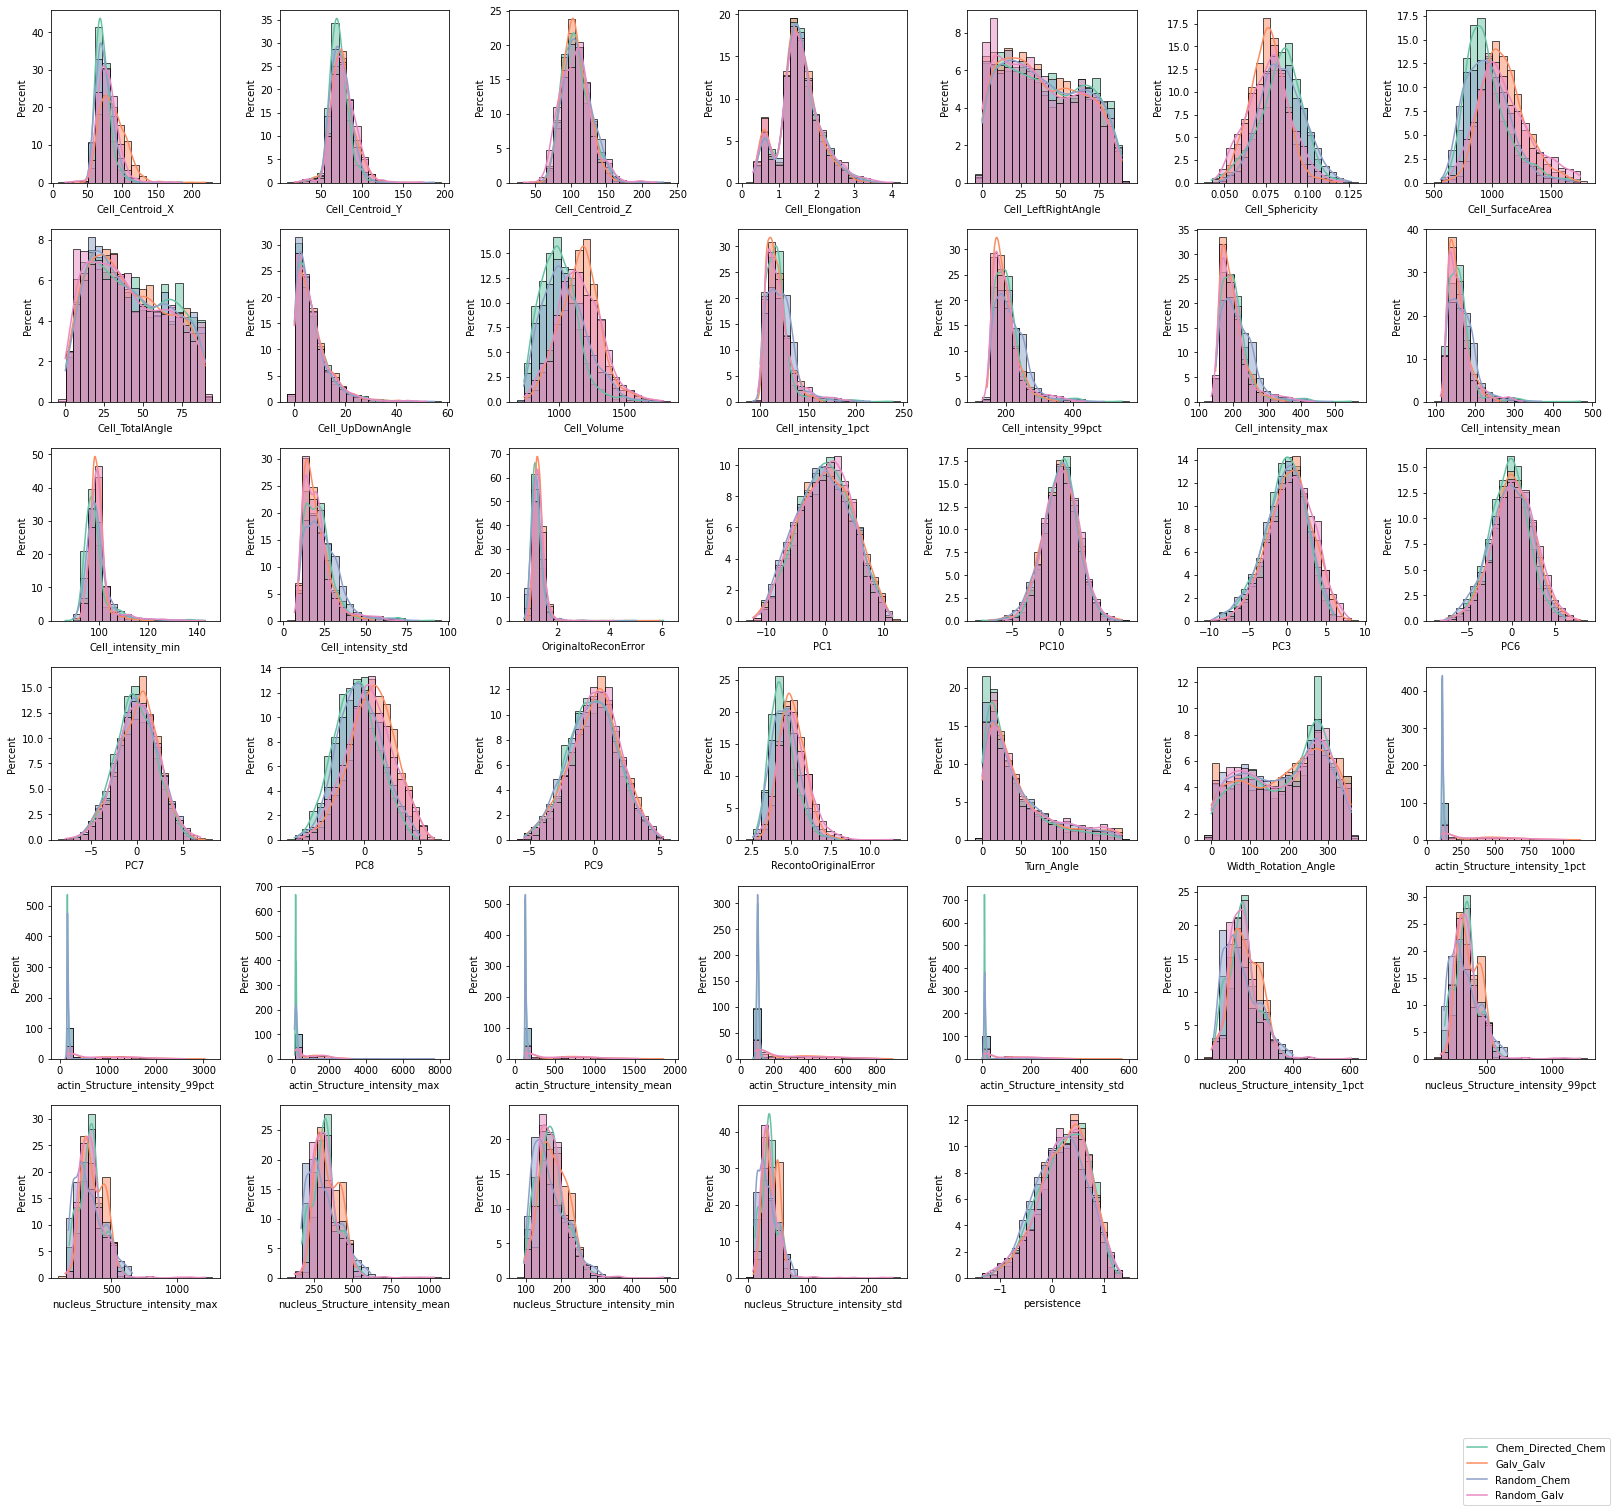

In [68]:
############### get list of metrics that are significant by migration mode using anova ############
ModeFrame = TotalFrame.copy()

import scipy.stats as ss
siglist = []
new_remove = to_remove.copy()
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'cell' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'frame' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'angle' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'avg' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'dist' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'activity' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'structure' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'ID' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'Experiment' in x])
new_remove.extend([x for x in ModeFrame.columns.to_list() if 'Migration_Mode' in x])

for c in ModeFrame.drop(columns=new_remove).columns.to_list():
    samples = [g[1].dropna() for g in ModeFrame.groupby(['Migration_Mode','Experiment'])[c]]
    f_val, p_val = ss.f_oneway(*samples)
#     print(f'Name: {c}, F value: {f_val}, p value: {p_val}')
    if p_val < 0.05:
        siglist.append(c) 
siglist = sorted(siglist)
from statsmodels.stats.multicomp import pairwise_tukeyhsd
for c in siglist:
    print(f'Name {c}', pairwise_tukeyhsd(ModeFrame[c], 
                                         [one+'_'+two for one, two in zip(ModeFrame['Migration_Mode'].to_list(), ModeFrame['Experiment'].to_list())]))

# units= ['(a.u.)','(a.u.)','(µm$^3$)','(a.u.)','(a.u.)','(µm$^2$)','(µm$^3$)',
#         '(a.u.)','(a.u.)']


################# LOOK AT STAT DISTRIBUTIONS OF SIGNIFICANT STATS ######################
import seaborn as sns

colors = sns.color_palette("Set2")
colors = list(colors.as_hex())


# colors = list(sns.color_palette('deep').as_hex())

CoRo = math.ceil(math.sqrt(len(siglist)))
row = 0
fig, axes = plt.subplots(CoRo, CoRo, figsize=(3.2*CoRo,3*CoRo))#, sharex=True)

for i, met in enumerate(siglist):

    
    #get the metric in question separated by migration mode
    samples = [g[1].dropna() for g in ModeFrame.groupby(['Migration_Mode','Experiment'])[met]]
    
        
    #get bins so that the widths between all types are the same
    maxx = max([max(x) for x in samples])
    minn = min([min(x) for x in samples])
    binwidth = (maxx-minn)*0.05
    maxx = maxx + binwidth
    minn = minn - binwidth
    binss = np.linspace(minn,maxx,round((maxx-minn)/binwidth))
    
    #plot the data
    ax = axes[row,(i-((CoRo-1)*row)-row)]
    sns.histplot(ax = ax, data=samples[0], bins=binss, stat='percent', color = colors[0], kde = True)
    sns.histplot(ax = ax, data=samples[1], bins=binss, stat='percent', color = colors[1], kde = True)
    sns.histplot(ax = ax, data=samples[2], bins=binss, stat='percent', color = colors[2], kde = True)
    sns.histplot(ax = ax, data=samples[3], bins=binss, stat='percent', color = colors[3], kde = True)
#     ax.set_ylabel(met)#, fontsize = 1.75*CoRo)
    if (i+1)%(CoRo) ==0:
        row = row + 1


ax = axes[row,(i-((CoRo-1)*row)-row)]
fig.legend(['_'.join(g) for g, i in ModeFrame.groupby(['Migration_Mode','Experiment'])], loc = 'lower right')

#delete all of the subplots that are unused
for a in range(i,CoRo**2):
    fig.delaxes(axes[row,(a-((CoRo-1)*row)-row)])
    if (a+1)%(CoRo) ==0:
        row = row + 1

# #     ax.set_ylabel(Nucleus_Metrics.iloc[:,i].name)

# # axes[0,0].set_title("Cell", fontsize = 16)
# # axes[0,1].set_title("Nucleus", fontsize = 16)
# # [ax.set_xlabel("Component value") for ax in axes[-1,:]];
# plt.legend(ModeFrame.Migration_Mode.unique(), loc ='lower right')
plt.tight_layout()
# plt.savefig(folder_fl + 'Significant Shape Metric Histograms.png', bbox_inches='tight')

C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator


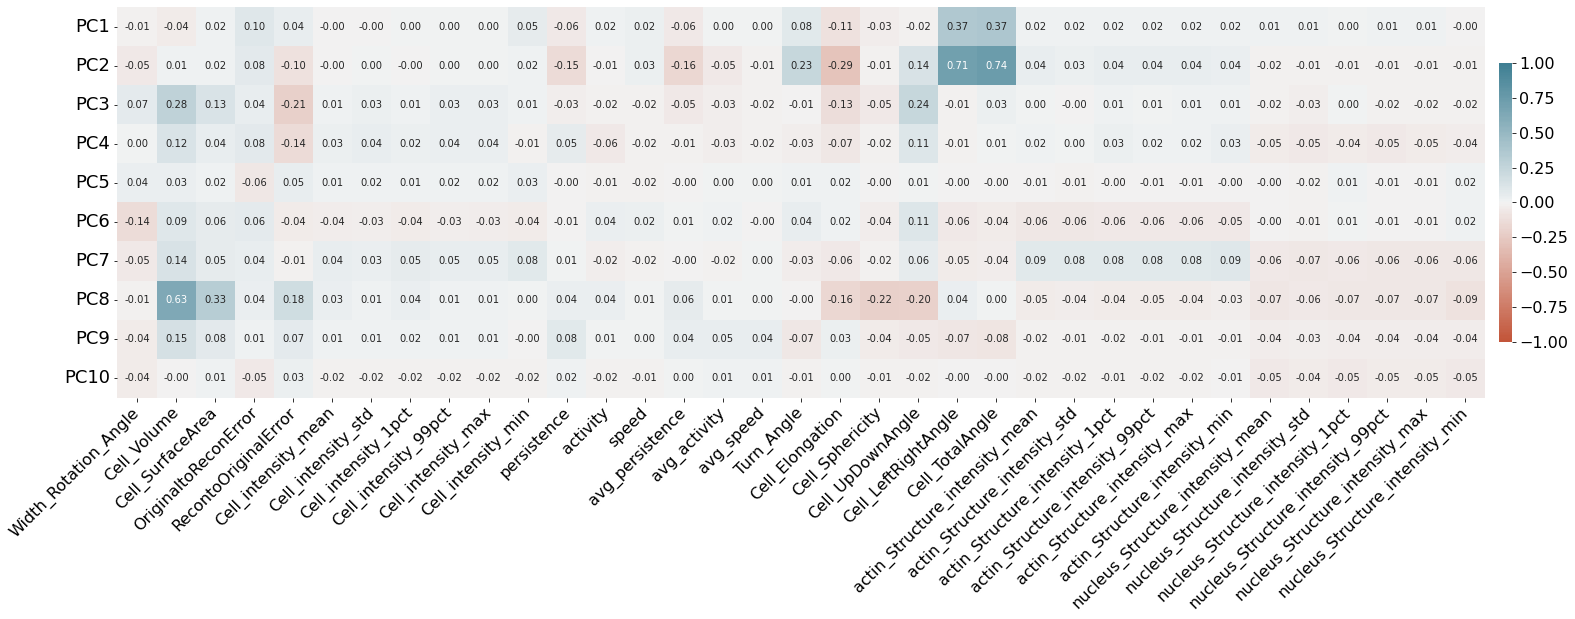

In [28]:
#correlations of shapes with PCs (PCs as rows)

coldrop = []
coldrop.extend([x for x in totalcorr.columns.to_list() if 'delta' in x])
coldrop.extend([x for x in totalcorr.columns.to_list() if 'PC' in x])
coldrop.extend([x for x in TotalFrame.columns.to_list() if 'Euler' in x])
coldrop.extend([x for x in TotalFrame.columns.to_list() if 'Centroid' in x])
coldrop.extend(['frame','dist'])

PCsAndMetrics = totalcorr.loc[[x for x in totalcorr.index if 'PC' in x and 'delta' not in x]]
PCsAndMetrics = PCsAndMetrics.drop(columns = coldrop)
fig, ax = plt.subplots(figsize=(25,15))
ax = sns.heatmap(
    PCsAndMetrics, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    xticklabels = True,
    yticklabels = True,
    annot = True,
    fmt = '.2f',
    cbar_kws={'fraction':0.01, 'pad':0.01}#, 'shrink': 0.5}
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right',
    fontsize = 16
)
ax.set_yticklabels(
    ax.get_yticklabels(),
    rotation=0,
    va = 'center',
    fontsize = 18
)
#scooch the x axis labels by a certain amount
dx = 6/72.; dy = 0/72. 
offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
cbar = ax.collections[0].colorbar
cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(),fontsize=16)

plt.savefig(folder_fl + 'PC correlation with shape metrics heatmap.png', bbox_inches='tight')

In [19]:
len(PCsAndMetrics.columns)

48

C:\Users\Aaron\anaconda3\envs\shape\lib\site-packages\ipykernel_launcher.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator


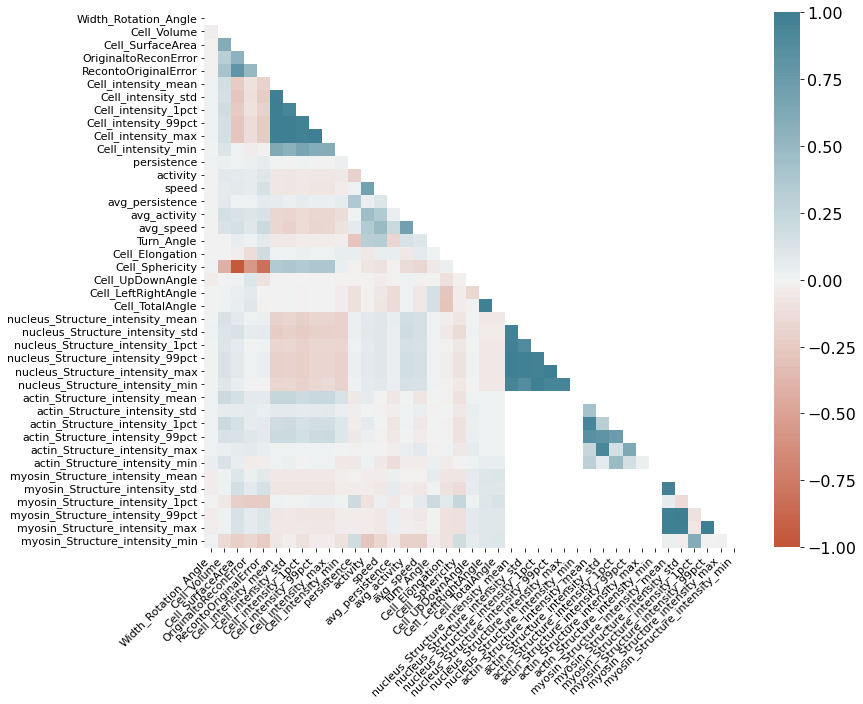

In [28]:
#get columns with nucleus and rows with cells from correlation matrix
coldrop = []
coldrop.extend([x for x in TotalFrame.columns.to_list() if 'Euler' in x])
coldrop.extend([x for x in TotalFrame.columns.to_list() if 'Centroid' in x])
coldrop.extend(['frame','dist'])

PartFramecorr = TotalFrame.drop(columns = to_remove)
PartFramecorr = PartFramecorr.drop(columns = coldrop)
PartFramecorr = PartFramecorr.drop(columns = ([i for i in PartFramecorr.columns.to_list() if 'PC' in i]))
PartFramecorr = PartFramecorr.drop(columns = ([x for x in PartFramecorr.columns.to_list() if 'delta' in x]))
PartFramecorr = PartFramecorr.corr()

#comparison of CELL features
mask = np.zeros_like(PartFramecorr)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(12,12))
ax = sns.heatmap(
    PartFramecorr,
    mask = mask,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    xticklabels = True,
    yticklabels = True,
    cbar_kws={'shrink': 0.82}
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right',
    fontsize = 11
)
ax.set_yticklabels(
    ax.get_yticklabels(),
    fontsize = 11
)
cbar = ax.collections[0].colorbar
cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(),fontsize=16)
figsize = (5, 30)
plt.savefig(folder_fl + ' Shape Metric corr.png', bbox_inches='tight')

C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator


NameError: name 'folder_fl' is not defined

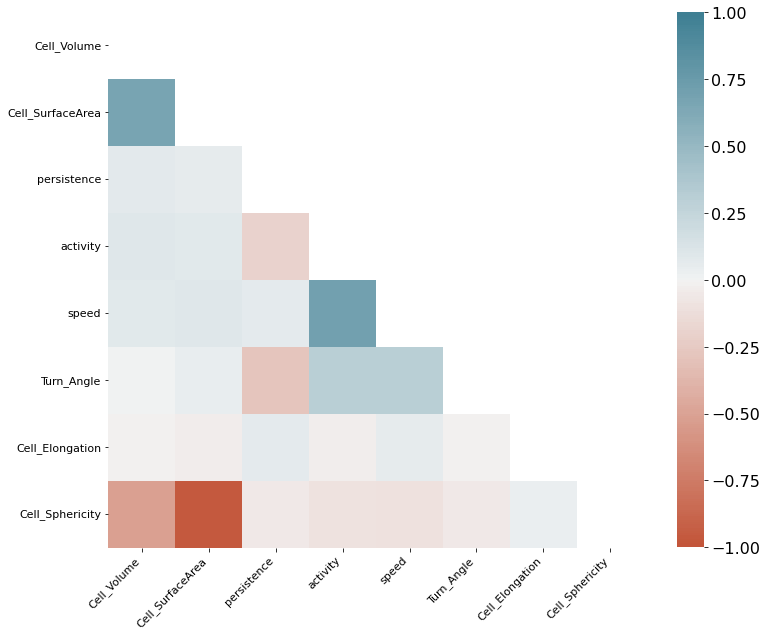

In [6]:
#get columns with nucleus and rows with cells from correlation matrix SMALLER
coldrop = []
coldrop.extend([x for x in TotalFrame.columns.to_list() if 'Euler' in x])
coldrop.extend([x for x in TotalFrame.columns.to_list() if 'Centroid' in x])
coldrop.extend([x for x in TotalFrame.columns.to_list() if 'Cell_int' in x])
coldrop.extend([x for x in TotalFrame.columns.to_list() if 'actin' in x])
coldrop.extend([x for x in TotalFrame.columns.to_list() if 'nucleus' in x])
coldrop.extend([x for x in TotalFrame.columns.to_list() if 'myosin' in x])
coldrop.extend([x for x in TotalFrame.columns.to_list() if 'Error' in x])
coldrop.extend([x for x in TotalFrame.columns.to_list() if 'avg' in x])
coldrop.extend(['frame','dist','Cell_UpDownAngle',
                'Cell_LeftRightAngle','Cell_TotalAngle', 'Width_Rotation_Angle',
               'x','y','z'])

PartFramecorr = TotalFrame.drop(columns = to_remove)
PartFramecorr = PartFramecorr.drop(columns = coldrop)
PartFramecorr = PartFramecorr.drop(columns = ([i for i in PartFramecorr.columns.to_list() if 'PC' in i]))
PartFramecorr = PartFramecorr.drop(columns = ([x for x in PartFramecorr.columns.to_list() if 'delta' in x]))
PartFramecorr = PartFramecorr.corr()

#comparison of CELL features
mask = np.zeros_like(PartFramecorr)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(12,12))
ax = sns.heatmap(
    PartFramecorr,
    mask = mask,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    xticklabels = True,
    yticklabels = True,
    cbar_kws={'shrink': 0.82}
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right',
    fontsize = 11
)
ax.set_yticklabels(
    ax.get_yticklabels(),
    fontsize = 11
)
cbar = ax.collections[0].colorbar
cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(),fontsize=16)
figsize = (5, 30)
plt.savefig(folder_fl + ' Shape Metric corr.png', bbox_inches='tight')

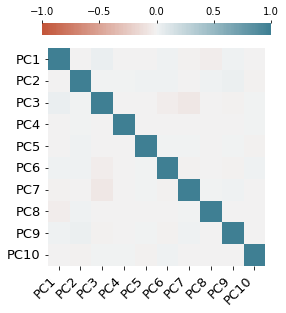

In [65]:
########################## PC Correlations #################

PCcorr = totalcorr.loc[[x for x in list(totalcorr.columns) if 'PC' in x and 'dist' not in x]].loc[:,[x for x in list(totalcorr.columns) if 'PC' in x and 'dist' not in x]]



#comparison of CELL features
fig, ax = plt.subplots(figsize=(5,5))
ax = sns.heatmap(
    PCcorr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    xticklabels = True,
    yticklabels = True,
    cbar_kws={'shrink': 0.82,
             'orientation':'horizontal',
             'location':'top'}
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right',
    fontsize = 13
)
ax.set_yticklabels(
    ax.get_yticklabels(),
    fontsize = 13
)
cbar = ax.collections[0].colorbar
cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(),fontsize=50)

plt.savefig(savedir + 'random graph for horizontal colorbar.png', bbox_inches='tight', dpi = 500)

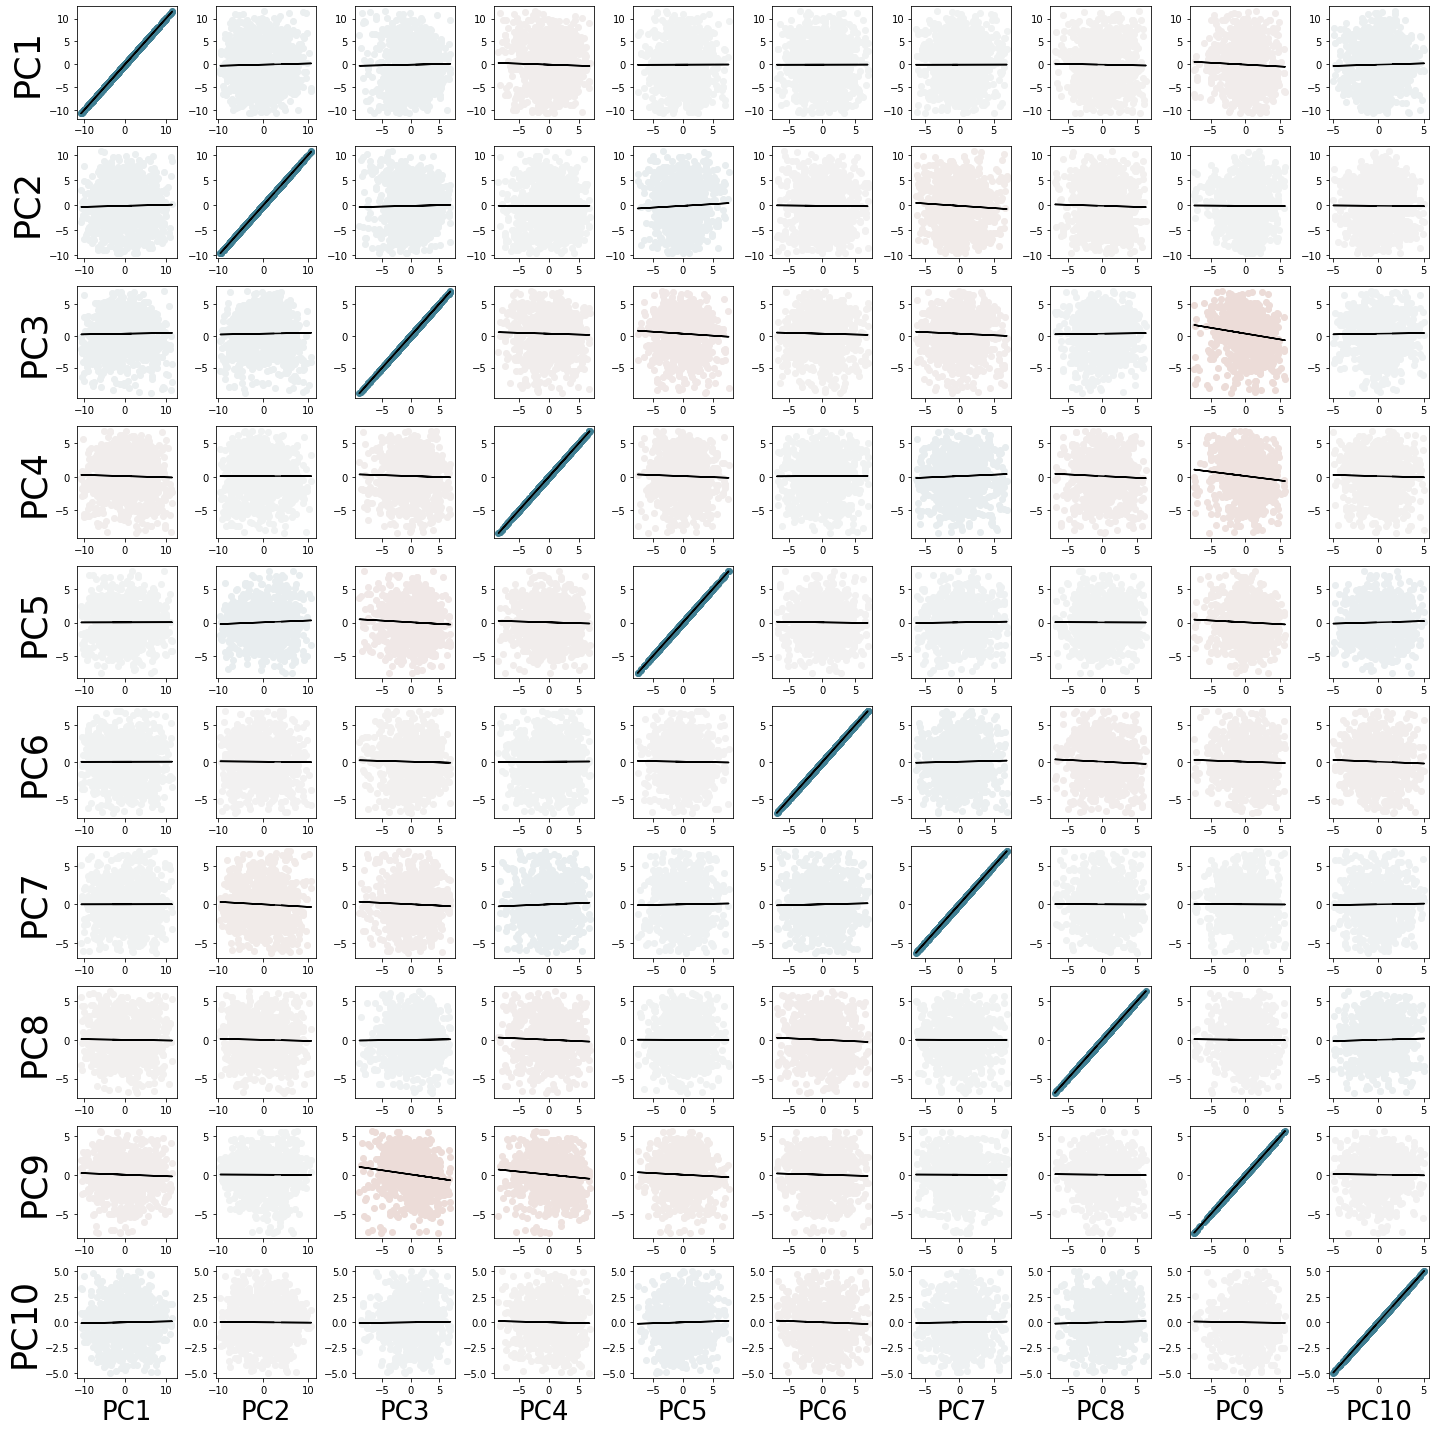

In [15]:
##################### look at scatter correlations between all PCs ###################

def closest(lst, K):  
    return lst[min(range(len(lst)), key = lambda i: abs(lst[i]-K))]
color_scale = pd.DataFrame({'color':list(sns.diverging_palette(20, 220, n=200).as_hex()),
              'value':list(np.arange(-1,1,2/200))})
#Scatter plots for cell metrics and the PCs
PC_frame = TotalFrame.loc[:,[x for x in list(TotalFrame.columns) if 'PC' in x]]
PC_frame = PC_frame.loc[:,[x for x in list(PC_frame.columns) if 'bin' not in x]]

fig, axes = plt.subplots(len(PC_frame.columns), len(PC_frame.columns), figsize=(20,20))#, sharex=True)
for q in range(axes.shape[0]):
    for i, ax in enumerate(axes[q,:]):
        x = PC_frame[f'PC{i+1}']
        y = PC_frame[f'PC{q+1}']
        coef = np.polyfit(x,y,1)
        poly1d_fn = np.poly1d(coef) 
        p_corr = totalcorr.loc[f'PC{q+1}', f'PC{i+1}']
        color = color_scale.color.loc[color_scale.value == closest(list(color_scale.value), p_corr)].values[0]
        ax.scatter(x,y, color = color)
        ax.plot(x, poly1d_fn(x), 'k')




# metric_names = [Shape_Metrics.Cell_Volume.name, 
#                RelativeVectors.Y.name, RelativeVectors.Z.name, 
#                'Y+Z', 
#                RandomRotations.Wide_Variance.name,
#                RelativeAngles.PitchAngle.name,
#                RelativeAngles.RollAngle.name,
#                RelativeAngles.PitchAngleNorm.name,
#               RelativeAngles.RollAngleNorm.name#,
# #                Shape_Metrics.Tilt.name
#                ]

# axes[0,0].set_title("PC 1")
# axes[0,1].set_title("PC 2")
# axes[0,2].set_title("PC 3")
xlabels = PC_frame.columns
[ax.set_ylabel(PC_frame.columns[i], fontsize = 35) for i, ax in enumerate(axes[:,0])];
[ax.set_xlabel(xlabels[i], fontsize = 26) for i, ax in enumerate(axes[-1,:])];

plt.tight_layout()
# plt.savefig(folder_fl+ 'PC vs. Metric scatter matrix.png', bbox_inches='tight')

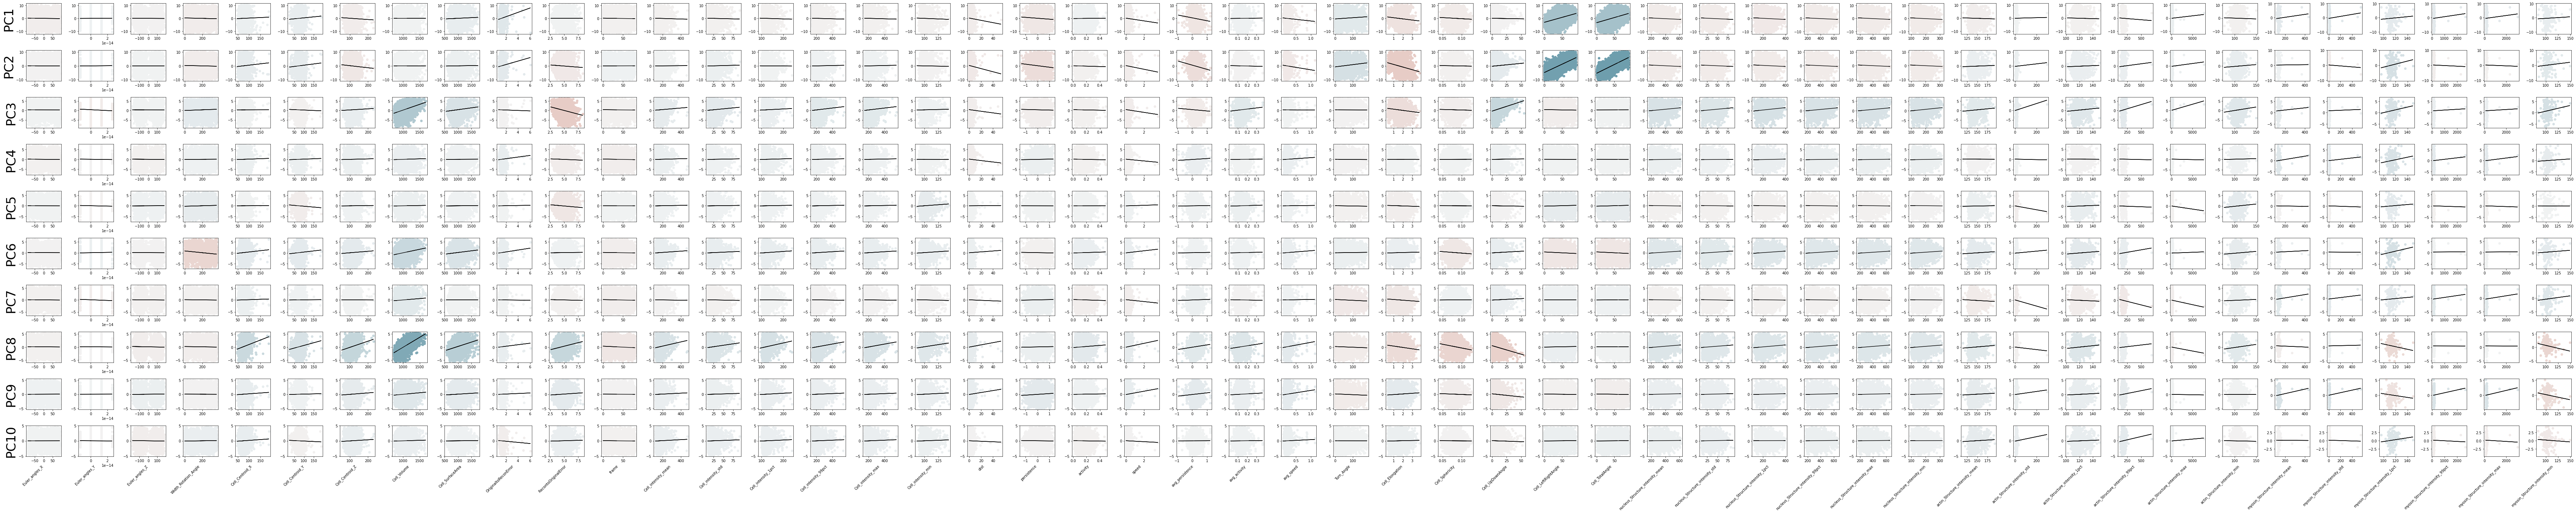

In [8]:
def closest(lst, K):  
    return lst[min(range(len(lst)), key = lambda i: abs(lst[i]-K))]
color_scale = pd.DataFrame({'color':list(sns.diverging_palette(20, 220, n=200).as_hex()),
              'value':list(np.arange(-1,1,2/200))})
#Scatter plots for cell metrics and the PCs
#stats to remove, if any
coldrop = [i for i in TotalFrame.columns.to_list() if 'PC' in i] 
coldrop.extend([i for i in TotalFrame.columns.to_list() if 'bin' in i])
coldrop.extend([i for i in TotalFrame.columns.to_list() if 'cell' in i])
coldrop.extend([i for i in TotalFrame.columns.to_list() if 'CellID' in i])
coldrop.extend([i for i in TotalFrame.columns.to_list() if 'structure' in i])
coldrop.extend([i for i in TotalFrame.columns.to_list() if 'Migration' in i])
coldrop.extend(to_remove)
# metric_frame = metric_frame.drop(columns=list(set(metric_frame.columns.to_list()).intersection(to_remove)))
metric_frame = TotalFrame.drop(columns=coldrop)

PC_frame = TotalFrame.loc[:,[x for x in list(TotalFrame.columns) if 'PC' in x]]
PC_frame = PC_frame.loc[:,[x for x in list(PC_frame.columns) if 'bin' not in x]]
PC_frame = PC_frame.loc[:,[x for x in list(PC_frame.columns) if 'delta' not in x]]

cols = metric_frame.columns.to_list()
fig, axes = plt.subplots(len(PC_frame.columns), len(metric_frame.columns), figsize=(100,20))#, sharex=True)
for q in range(axes.shape[0]):
    for i, ax in enumerate(axes[q,:]):
        rows = metric_frame.iloc[:,i][metric_frame.iloc[:,i].isna() == False].index.to_list()
        x = metric_frame.loc[rows,cols[i]]
        y = PC_frame.loc[rows,f'PC{q+1}']
        coef = np.polyfit(x,y,1)
        poly1d_fn = np.poly1d(coef) 
        p_corr = totalcorr.loc[f'PC{q+1}', metric_frame.iloc[:,i].name]
        color = color_scale.color.loc[color_scale.value == closest(list(color_scale.value), p_corr)].values[0]
        ax.scatter(x,y, color = color)
        ax.plot(x, poly1d_fn(x), 'k')
#         ax.text(0.1,0.1,str(np.around(p_corr, decimals=2)))



# metric_names = [Shape_Metrics.Cell_Volume.name, 
#                RelativeVectors.Y.name, RelativeVectors.Z.name, 
#                'Y+Z', 
#                RandomRotations.Wide_Variance.name,
#                RelativeAngles.PitchAngle.name,
#                RelativeAngles.RollAngle.name,
#                RelativeAngles.PitchAngleNorm.name,
#               RelativeAngles.RollAngleNorm.name#,
# #                Shape_Metrics.Tilt.name
#                ]

# axes[0,0].set_title("PC 1")
# axes[0,1].set_title("PC 2")
# axes[0,2].set_title("PC 3")
# xlabels = [x.replace('_','\n') for x in metric_frame.columns]
[ax.set_ylabel(PC_frame.columns[i], fontsize = 35) for i, ax in enumerate(axes[:,0])];
[ax.set_xlabel(metric_frame.columns[i], rotation=45, horizontalalignment='right', fontsize = 10) for i, ax in enumerate(axes[-1,:])];

plt.tight_layout()
plt.savefig(folder_fl+ 'PC vs. Metric scatter matrix.png', bbox_inches='tight')

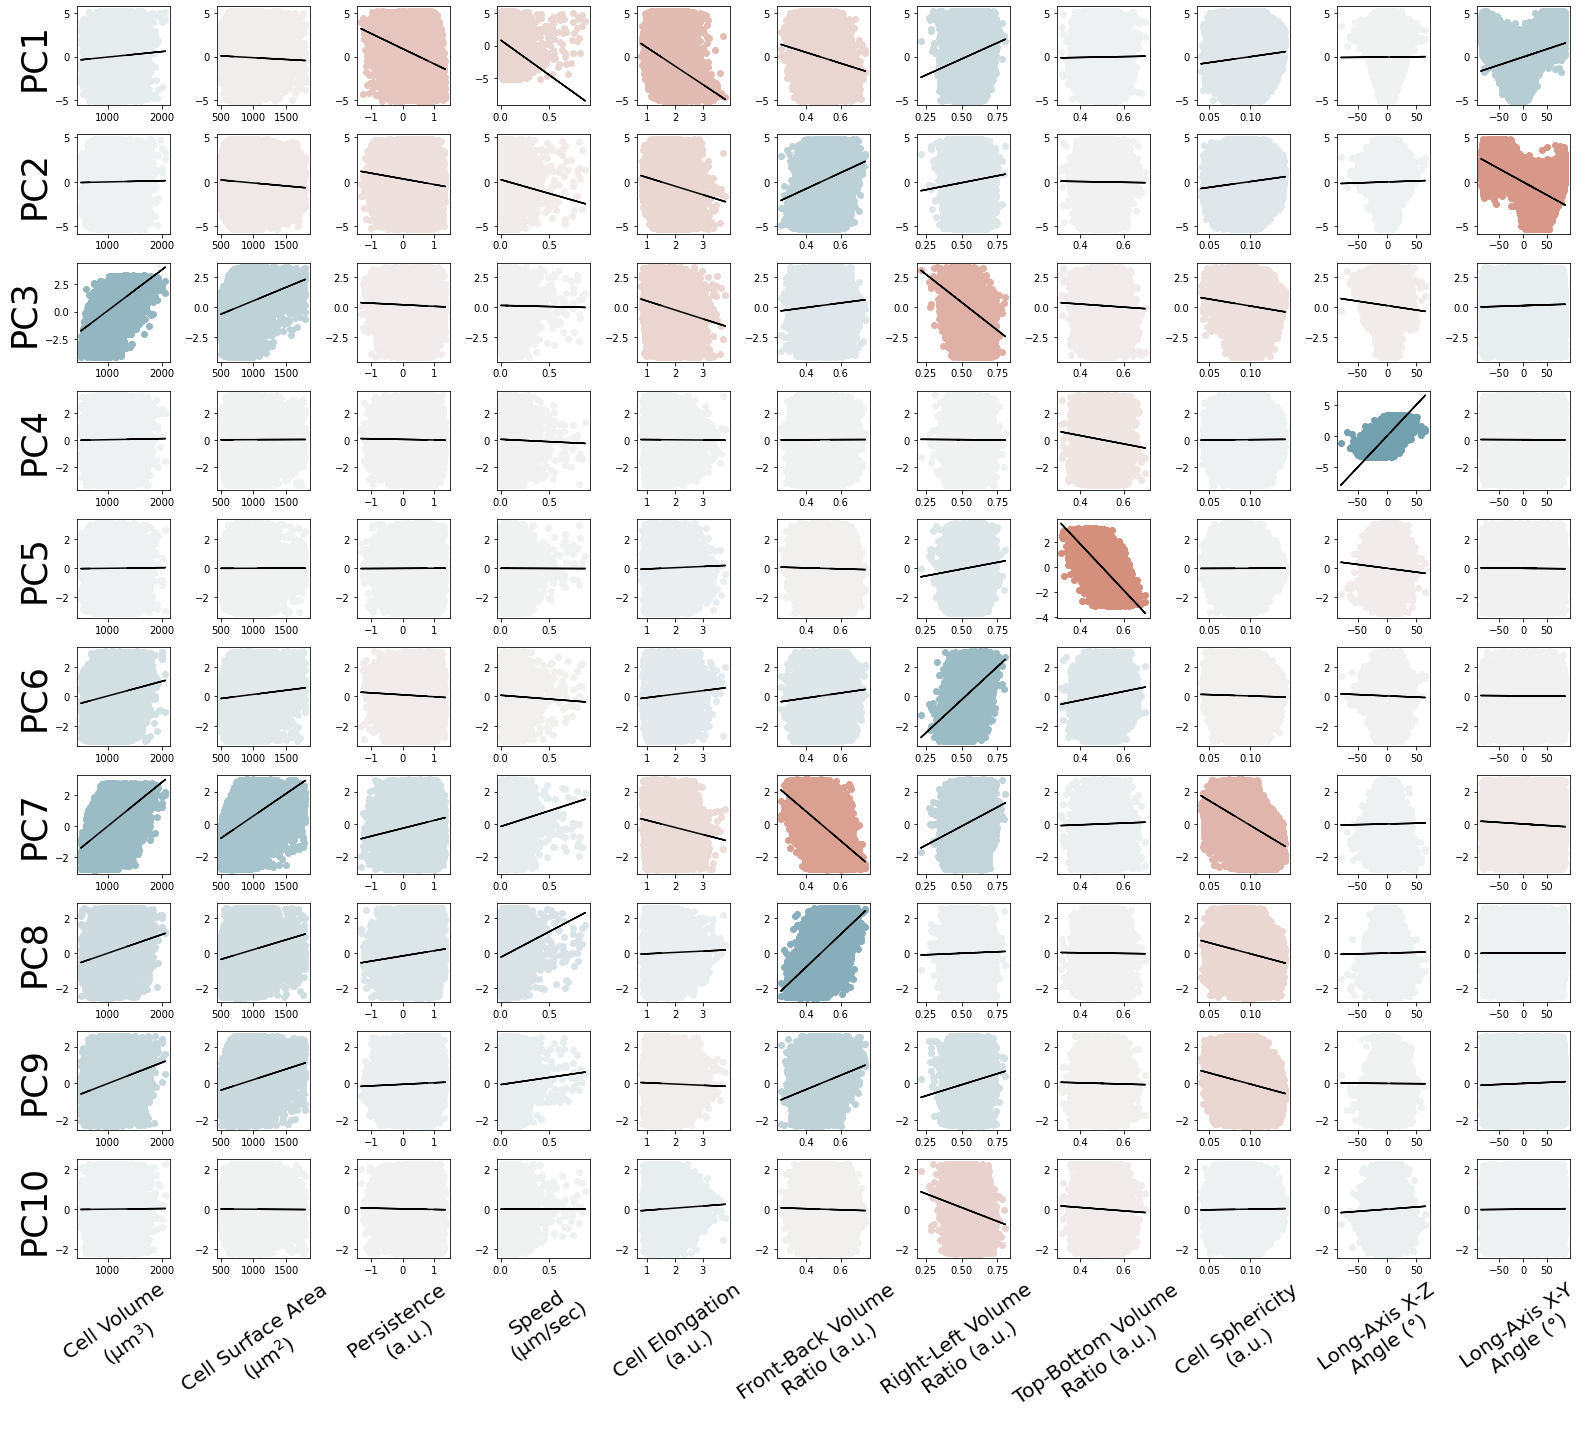

In [48]:
################ smaller PC vs metric plots for CICON ################

def closest(lst, K):  
    return lst[min(range(len(lst)), key = lambda i: abs(lst[i]-K))]
color_scale = pd.DataFrame({'color':list(sns.diverging_palette(20, 220, n=200).as_hex()),
              'value':list(np.arange(-1,1,2/200))})
#Scatter plots for cell metrics and the PCs
#stats to remove, if any
coldrop = [i for i in TotalFrame.columns.to_list() if 'PC' in i] 
coldrop.extend([i for i in TotalFrame.columns.to_list() if 'bin' in i])
coldrop.extend([i for i in TotalFrame.columns.to_list() if 'cell' in i])
coldrop.extend([i for i in TotalFrame.columns.to_list() if 'CellID' in i])
coldrop.extend([i for i in TotalFrame.columns.to_list() if 'structure' in i])
coldrop.extend([i for i in TotalFrame.columns.to_list() if 'Migration' in i])
coldrop.extend([x for x in TotalFrame.columns.to_list() if 'Euler' in x])
coldrop.extend([x for x in TotalFrame.columns.to_list() if 'Centroid' in x])
coldrop.extend([x for x in TotalFrame.columns.to_list() if 'Cell_int' in x])
coldrop.extend([x for x in TotalFrame.columns.to_list() if 'actin' in x])
coldrop.extend([x for x in TotalFrame.columns.to_list() if 'nucleus' in x])
coldrop.extend([x for x in TotalFrame.columns.to_list() if 'myosin' in x])
coldrop.extend([x for x in TotalFrame.columns.to_list() if 'Error' in x])
coldrop.extend([x for x in TotalFrame.columns.to_list() if 'avg' in x])
coldrop.extend([x for x in TotalFrame.columns.to_list() if 'diff' in x])
coldrop.extend([x for x in TotalFrame.columns.to_list() if 'Cell_Volume_' in x])
coldrop.extend(['frame','dist','Width_Rotation_Angle','x','y','z','activity','Cell_TotalAngle', 'Turn_Angle'])
coldrop.extend(to_remove)
# metric_frame = metric_frame.drop(columns=list(set(metric_frame.columns.to_list()).intersection(to_remove)))
metric_frame = TotalFrame.drop(columns=coldrop)
#cut out speed outliers
metric_frame = metric_frame[metric_frame.speed<1]


PC_frame = TotalFrame.loc[:,[x for x in list(TotalFrame.columns) if 'PC' in x]]
PC_frame = PC_frame.loc[:,[x for x in list(PC_frame.columns) if 'bin' not in x]]
PC_frame = PC_frame.loc[:,[x for x in list(PC_frame.columns) if 'dist' not in x]]
PC_frame = PC_frame.loc[:,[x for x in list(PC_frame.columns) if 'delta' not in x]]



cols = metric_frame.columns.to_list()
fig, axes = plt.subplots(len(PC_frame.columns), len(metric_frame.columns), figsize=(22,20))#, sharex=True)
for q in range(axes.shape[0]):
    for i, ax in enumerate(axes[q,:]):
        rows = metric_frame.iloc[:,i][metric_frame.iloc[:,i].isna() == False].index.to_list()
        x = metric_frame.loc[rows,cols[i]]
        y = PC_frame.loc[rows,f'PC{q+1}']
        coef = np.polyfit(x,y,1)
        poly1d_fn = np.poly1d(coef) 
        p_corr = totalcorr.loc[f'PC{q+1}', metric_frame.iloc[:,i].name]
        color = color_scale.color.loc[color_scale.value == closest(list(color_scale.value), p_corr)].values[0]
        ax.scatter(x,y, color = color)
        ax.plot(x, poly1d_fn(x), 'k')
#         ax.text(0.1,0.1,str(np.around(p_corr, decimals=2)))



# metric_names = [Shape_Metrics.Cell_Volume.name, 
#                RelativeVectors.Y.name, RelativeVectors.Z.name, 
#                'Y+Z', 
#                RandomRotations.Wide_Variance.name,
#                RelativeAngles.PitchAngle.name,
#                RelativeAngles.RollAngle.name,
#                RelativeAngles.PitchAngleNorm.name,
#               RelativeAngles.RollAngleNorm.name#,
# #                Shape_Metrics.Tilt.name
#                ]

# axes[0,0].set_title("PC 1")
# axes[0,1].set_title("PC 2")
# axes[0,2].set_title("PC 3")
# xlabels = [x.replace('_','\n') for x in metric_frame.columns]
[ax.set_ylabel(PC_frame.columns[i], fontsize = 35) for i, ax in enumerate(axes[:,0])];
labelz = ['Cell Volume\n(µm$^3$)','Cell Surface Area\n(µm$^2$)','Persistence\n(a.u.)','Speed\n(µm/sec)','Cell Elongation\n(a.u.)',
          'Front-Back Volume\nRatio (a.u.)','Right-Left Volume\nRatio (a.u.)','Top-Bottom Volume\nRatio (a.u.)',
          'Cell Sphericity\n(a.u.)','Long-Axis X-Z\nAngle (°)','Long-Axis X-Y\nAngle (°)']
[ax.set_xlabel(labelz[i], rotation=35, horizontalalignment='center', fontsize = 20) for i, ax in enumerate(axes[-1,:])];

plt.tight_layout()
plt.savefig(savedir+ 'PC vs. Metric scatter matrix for ASCB2023.png', bbox_inches='tight', dpi=500)